This notebook focuses on architectures where the **LSTM is the first layer of the network followed by some CNN layers**.

Key models are made as headings and listed here for ease of searching:

LSTM - 1; LSTM - 2; ConvLSTM; LSTM-CNN_adaptive reg -1; LSTM - CNN_adaptive reg-2; LSTM - CNN_adaptive reg-3;LSTM - CNN_adaptive reg-4; LSTM-CNN-1_constant reg; LSTM-CNN-2_constant reg; Scheduled Sampling of inputs; Inputs in form of a spatial map of electrodes; Training on individual persons

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
#drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
% cd 'drive/My Drive/C247_Project_Personal/project_data/project'
#% cd 'drive/My Drive/C247_Data'
% ls

/content/drive/My Drive/C247_Project_Personal/project_data/project
 best_model.h5                     'Person_5.0_22_training e250.h5'
 CropImg_e300.h5                   'Person_5.0 training e250.h5'
 CropImg_noLSTM_e300.h5            'Person_6.0_22_training e250.h5'
 EEG_loading.ipynb                 'Person_6.0 training e250.h5'
 multi_input_and_output_model.png  'Person_7.0_22_training e250.h5'
'Person_0.0_22_training e250.h5'   'Person_7.0 training e250.h5'
'Person_0.0 training e250.h5'      'Person_8.0_22_training e250.h5'
'Person_1.0_22_training e250.h5'   'Person_8.0 training e250.h5'
'Person_1.0 training e250.h5'       person_test.npy
'Person_2.0_22_training e250.h5'    person_train_valid.npy
'Person_2.0 training e250.h5'       Shal_lstm_val5009_03_time05_08.pth
'Person_3.0_22_training e250.h5'    X_test.npy
'Person_3.0 training e250.h5'       X_train_valid.npy
'Person_4.0_22_training e250.h5'    y_test.npy
'Person_4.0 training e250.h5'       y_train_valid.npy


###Import required modules

In [ ]:
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import callbacks

from time import time
import matplotlib.pyplot as plt
from matplotlib import offsetbox

In [ ]:
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

In [ ]:
from tensorflow.keras import regularizers

### User defined functions

crop_data function converts each given trial into crops of more samples
 
 X: shape(trials, electrodes, timesteps)
 
 Xnew: shape(trials*num of samples per trial, electrodes, reduced time windows
       

In [ ]:
def crop_data(X, y, wlen, stride):
  trials, elec, ts = X.shape
  n_samp = (ts-wlen)//stride + 1
  Xnew = np.zeros((n_samp*trials, elec, wlen))
  ynew = np.zeros((n_samp*trials,))
  for i in range(trials):
    for j in range(n_samp):
      Xnew[i*n_samp+j, :,:] = X[i, :, j*stride:wlen+j*stride]
      ynew[i*n_samp+j] = y[i]
  return Xnew, ynew

crop_2Ddata (similar to crop_data) converts a 2D map of the electrodes into more samples with cropped time windows.

In [ ]:
def crop_2Ddata(X, y, wlen, stride):
  trials, r, h, ts = X.shape
  n_samp = (ts-wlen)//stride + 1
  Xnew = np.zeros((n_samp*trials, r, h, wlen))
  ynew = np.zeros((n_samp*trials,))
  for i in range(trials):
    for j in range(n_samp):
      Xnew[i*n_samp+j, :,:,:] = X[i, :,:, j*stride:wlen+j*stride]
      ynew[i*n_samp+j] = y[i]
  return Xnew, ynew

Loss_big_img plot the training and validation loss w.r.t epochs after completing the training.

In [ ]:
def Loss_big_img(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'Valid'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'Valid'], loc='upper left')
    plt.show()

PlotLosses class: for plotting live losses during training

In [ ]:
class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
#plot_losses = PlotLosses()

PlotLearning class: for plotting live losses and accuracies during training.

In [ ]:
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure(figsize=(10,10))
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        #f(figsize=(4,4))
        #f.set_figwidth(4) 
        #f.set_figheight(4)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot_losses = PlotLearning()

get_cb function: creates useful callback options

In [ ]:
def get_cb(model_name):
    c_callbacks = [
        callbacks.ModelCheckpoint(
            "{}.h5".format(model_name), save_best_only=True, monitor="val_loss"
        ),
        callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=20, min_lr=0.00001
        ),
        callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
        plot_losses,
    ]
    return c_callbacks

### Data Loading into numpy

In [ ]:
X_test = np.load("X_test.npy")
X_train_valid = np.load("X_train_valid.npy")

y_test = np.load("y_test.npy")
y_train_valid = np.load("y_train_valid.npy")

person_test = np.load("person_test.npy")
person_train_valid = np.load("person_train_valid.npy")

# adjust labels to be between [0,1,2,3]
y_train_valid -= 769
y_test -= 769

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [ ]:
np.unique(y_train_valid)

array([0, 1, 2, 3], dtype=int32)

### Rearranging each instant into a 6x7 map

Example to check if first electrode has positon 0,3: True
All test assignments correct: True
All train assignments correct: True


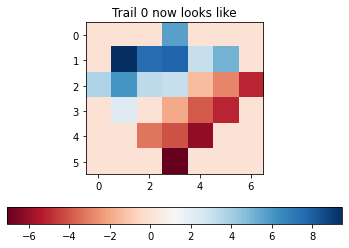

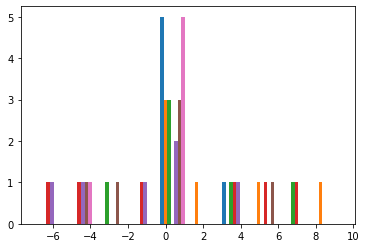

In [ ]:
new_test = np.zeros((443, 6, 7, 1000)) 

new_test[:,:,3,:] = X_test[:,np.array([1,4,10,16,20,22])-1,:]
new_test[:,[1,2,3,4],[2],:] = X_test[:,np.array([3,9,15,19])-1,:]
new_test[:,[1,2,3,4],[4],:] = X_test[:,np.array([5,11,17,21])-1,:]
new_test[:,[1,2,3],[1],:] = X_test[:,np.array([2,8,14])-1,:]
new_test[:,[1,2,3],[5],:] = X_test[:,np.array([6,12,18])-1,:]

new_test[:,2,[0,6],:] = X_test[:,np.array([7,13])-1,:]

#Rearrange train data at each time instant as a 6x7 map of electrodes
new_train_valid = np.zeros((2115, 6, 7, 1000)) 

new_train_valid[:,:,3,:] = X_train_valid[:,np.array([1,4,10,16,20,22])-1,:]
new_train_valid[:,[1,2,3,4],[2],:] = X_train_valid[:,np.array([3,9,15,19])-1,:]
new_train_valid[:,[1,2,3,4],[4],:] = X_train_valid[:,np.array([5,11,17,21])-1,:]
new_train_valid[:,[1,2,3],[1],:] = X_train_valid[:,np.array([2,8,14])-1,:]
new_train_valid[:,[1,2,3],[5],:] = X_train_valid[:,np.array([6,12,18])-1,:]

new_train_valid[:,2,[0,6],:] = X_train_valid[:,np.array([7,13])-1,:]

#check whether assignment was proper:
#spatially the electrodes are on a 6x7 rectangle on the scalp.
#new_ind[i] stores the electrode position on the 6x7 map
#Eg: new_ind[21] gives the last electrode's position [5,3]

new_ind = np.zeros((22,2))
new_ind[0] = np.array([[0,3]])
new_ind[1:6] = np.array([[1,1], [1,2], [1,3], [1,4], [1,5]])
new_ind[6:13] = np.array([[2,0], [2,1], [2,2], [2,3], [2,4], [2,5], [2,6]])
new_ind[13:18] = np.array([[3,1], [3,2], [3,3], [3,4], [3,5]])
new_ind[18:21] = np.array([[4,2], [4,3], [4,4]])
new_ind[21] = np.array([[5,3]])
new_ind = new_ind.astype(int) #new_ind, shows the position of each electorode
#print("new_ind, shows the position of each electorode: ", new_ind)

#Example to check if first electrode has positon 0,3
check = np.all(X_test[:,0,:] == new_test[:,0,3,:])
print("Example to check if first electrode has positon 0,3:", check)

check_test = []
check_train_valid = []
for i in range(22):
    check_test.append(np.all(X_test[:,i,:] == new_test[:,new_ind[i,0], new_ind[i,1],:]))
    check_train_valid.append(np.all(X_train_valid[:,i,:] == new_train_valid[:,new_ind[i,0], new_ind[i,1],:]))
print("All test assignments correct:", np.all(check_test))
print("All train assignments correct:", np.all(check_train_valid))

#example plot
fig, ax1 = plt.subplots()
res = ax1.imshow(new_train_valid[0,:,:,0],cmap='RdBu')
ax1.set_title('Trail 0 now looks like')
fig.colorbar(res, ax=ax1, orientation="horizontal")
plt.show()
plt.hist(new_train_valid[0,:,:,0])
plt.show()

Permuting the axes so that the timesteps is the first index.

Adding an additional dimension at the end (to indicate number of channels in certian architectures.)

In [ ]:
#Rearranging 2D fields of electrode arrangement into inputs suitable for a ConvLSTM2D layer.
Xcrop_clstm_tv, ycropnew_tv = crop_2Ddata(new_train_valid, y_train_valid, 800, 50)
Xcrop_clstm_test, ycropnew_test = crop_2Ddata(new_test, y_test, 800, 50)

Xcrop_clstm_tv = np.transpose(Xcrop_clstm_tv, [0,3,1,2])
Xcrop_clstm_test = np.transpose(Xcrop_clstm_test, [0,3,1,2])
                                
Xcrop_clstm_tv = Xcrop_clstm_tv[:,:,:,:,np.newaxis]
Xcrop_clstm_test = Xcrop_clstm_test[:,:,:,:,np.newaxis]

In [ ]:
#Rearranging 2D fields of electrode arrangement into inputs if an LSTM and then conv layers are used.
new_lstm_tv= np.transpose(new_train_valid,[0,3,1,2])
new_lstm_test = np.transpose(new_test,[0,3,1,2])

new_lstm_tv = new_lstm_tv[:,:,:,:,np.newaxis]
new_lstm_test = new_lstm_test[:,:,:,:, np.newaxis]

print("New tv shape: {}".format(new_lstm_tv.shape))
print("New test shape: {}".format(new_lstm_test.shape))

print("New tv shape: {}".format(Xcrop_clstm_tv.shape))
print("New test shape: {}".format(Xcrop_clstm_test.shape))

New tv shape: (2115, 1000, 6, 7, 1)
New test shape: (443, 1000, 6, 7, 1)
New tv shape: (10575, 800, 6, 7, 1)
New test shape: (2215, 800, 6, 7, 1)


In [ ]:
#one-hot encoding
ycropnew_tv_onehot = tf.keras.utils.to_categorical(ycropnew_tv, 4)
ycropnew_test_onehot = tf.keras.utils.to_categorical(ycropnew_test, 4)

Finding a lower ranked approximation of the input **(de-noising)**

4


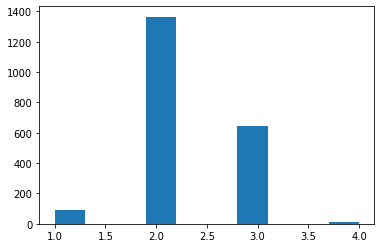

In [ ]:
trials = X_train_valid.shape[0]
elec = X_train_valid.shape[1]
ti = X_train_valid.shape[2]

X_train_r = np.transpose(X_train_valid,[0,2,1]) #Reordering into ti x elec shape
X_test_r = np.transpose(X_test,[0,2,1])

X_train_mean = np.mean(X_train_r, axis = 1)
X_train_mean = X_train_mean[:,np.newaxis,:]

X_train_r_m = X_train_r - X_train_mean
C = np.zeros((trials, elec, elec))
for i in range(trials):
    C[i,:,:] = X_train_r_m[i,:,:].T.dot(X_train_r_m[i,:,:])
C = C / (ti - 1)

#Computing evals
evals = np.zeros((trials,elec))
evec = np.zeros((trials,elec,elec))
#ind = np.zeros((trials,elec))
for i in range(trials):
    evals[i,:], evec[i,:,:] = np.linalg.eig(C[i,:,:])
    
#absevals = np.abs(evals)#Not needed since evals are real for a symmetric matrix

#Sort into decreasing strength of evals:
for i in range(trials):
    ind = np.argsort(evals[i,:])
    evals[i,:] = evals[i, np.flip(ind)]
    evec[i,:,:] = evec[i,:,np.flip(ind)]
    
#cum_sum
cum_ev_m = np.cumsum(evals, axis = 1)
sum_ev_m = np.sum(evals, axis = 1)
sum_ev_m = sum_ev_m[:, np.newaxis]

cum_ev_m = cum_ev_m/sum_ev_m
#95% of variance can be explained by:
indm = np.argmax(cum_ev_m>0.95, axis = 1)
print(np.max(indm))
plt.hist(indm)
plt.show()

A rank 5 approximation is sufficient in all cases to capture at least 95% of the variance. This was observed for the mean subtracted matrix.

Let us take rank 6 approximation of the given raw data.

In [ ]:
Xred_tv = np.zeros((trials, elec, ti)) #tv is short for train and valid data. Xred stands for reduced rank approximation. 
for i in range(trials):
    u_tv,s_tv,vh_tv = np.linalg.svd(X_train_valid[i,:,:], full_matrices = False)
    Xred_tv[i,:,:] = u_tv[:,:6]@np.diag(s_tv[:6])@vh_tv[:6,:]

Xred_test = np.zeros((X_test.shape[0], elec, ti))
for i in range(X_test.shape[0]):
    u_tv,s_tv,vh_tv = np.linalg.svd(X_test[i,:,:], full_matrices = False)
    Xred_test[i,:,:] = u_tv[:,:6]@np.diag(s_tv[:6])@vh_tv[:6,:]

#Reshaping data for LSTM layers
Xred_lstm_tv = np.transpose(Xred_tv,(0,2,1))
Xred_lstm_test = np.transpose(Xred_test,(0,2,1))

In [ ]:
X_lstm_tv = np.transpose(X_train_valid,(0,2,1))
X_lstm_test = np.transpose(X_test,(0,2,1))

In [ ]:
Xcrop_lstm_tv, ycrop_tv = crop_data(X_train_valid, y_train_valid, wlen = 800,stride = 50)
Xcrop_lstm_test, ycrop_test = crop_data(X_test, y_test, wlen = 800,stride = 50)

Xcrop_lstm_tv = np.transpose(Xcrop_lstm_tv,(0,2,1))
Xcrop_lstm_test = np.transpose(Xcrop_lstm_test,(0,2,1))

ycrop_tv_onehot = tf.keras.utils.to_categorical(ycrop_tv, 4)
ycrop_test_onehot = tf.keras.utils.to_categorical(ycrop_test, 4)

In [ ]:
#checking that the sequence labels were correctly split
print(np.max(ycrop_test[0::5] - ycrop_test[1::5]))
print(np.max(ycrop_test[1::5] - ycrop_test[2::5]))
print(np.max(ycrop_test[2::5] - ycrop_test[3::5]))
print(np.max(ycrop_test[3::5] - ycrop_test[4::5]))


0.0
0.0
0.0
0.0


In [ ]:
y_tv_onehot = tf.keras.utils.to_categorical(y_train_valid, 4)
y_test_onehot = tf.keras.utils.to_categorical(y_test, 4)

### LSTM-1

**Attempt:** Two LSTM layers at the beginning and then convolutions. The de-noised input matrix was sent as input.

In [ ]:
inputs = tf.keras.Input(shape=(1000,22))

out1, state_h, state_c = layers.LSTM(10, return_state=True, dropout = 0.2, name="LSTM1")(inputs)

state = [state_h, state_c]
out2 = layers.LSTM(10, name="LSTM2")(
    inputs, initial_state=state
)

out3 = layers.Dense(10, activation = 'relu')(out2)
out4 = layers.Dense(4, activation = 'softmax')(out3)

model = tf.keras.Model(inputs, out4)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1000, 22)]   0                                            
__________________________________________________________________________________________________
LSTM1 (LSTM)                    [(None, 10), (None,  1320        input_3[0][0]                    
__________________________________________________________________________________________________
LSTM2 (LSTM)                    (None, 10)           1320        input_3[0][0]                    
                                                                 LSTM1[0][1]                      
                                                                 LSTM1[0][2]                      
______________________________________________________________________________________________

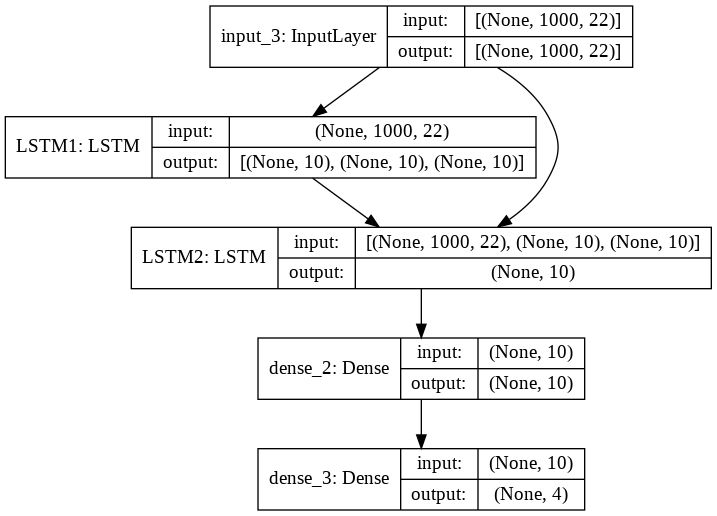

In [ ]:
plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

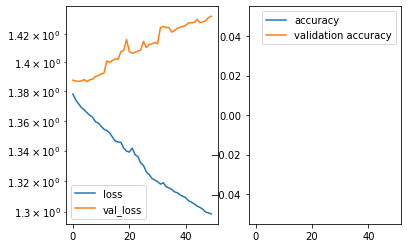

Val Accuracy 0.27895981073379517
Test Accuracy 0.18510158360004425


In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
model.compile(loss = 'sparse_categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy',"sparse_categorical_accuracy"])

X_train, X_val, y_train, y_val = train_test_split(Xred_lstm_tv, y_train_valid, test_size=0.2)
model.fit(X_train,y_train, batch_size = 64, epochs = 50, validation_data = (X_val,y_val), callbacks=callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(Xred_lstm_test,y_test, verbose = 0)
print('Test Accuracy', score[1])

Above gives poor performance. 

With regularization:

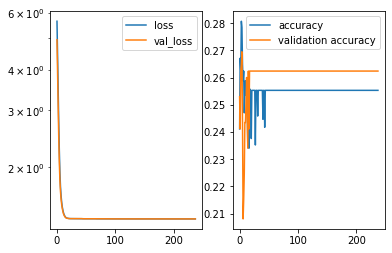

Epoch 00238: early stopping
Val Accuracy 0.26241135597229004
Test Accuracy 0.21670429408550262


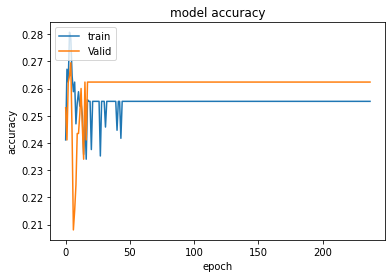

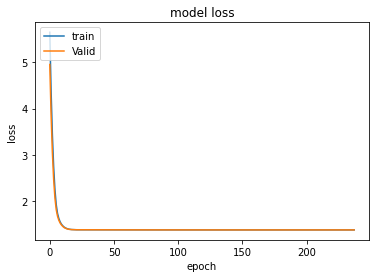

In [ ]:
reg = regularizers.l1_l2(l1=0.01, l2=0.01)
inputs = tf.keras.Input(shape=(1000,22))

out1, state_h, state_c = layers.LSTM(10, return_state=True,kernel_regularizer= reg,recurrent_regularizer= reg, dropout = 0.2, name="LSTM1")(inputs)

state = [state_h, state_c]
out2 = layers.LSTM(10,kernel_regularizer= reg,recurrent_regularizer= reg, name="LSTM2")(
    inputs, initial_state=state
)

out3 = layers.Dense(10,kernel_regularizer= reg, activation = 'relu')(out2)
out4 = layers.Dense(4, activation = 'softmax')(out3)

model = tf.keras.Model(inputs, out4)
#model.summary()
optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
model.compile(loss = 'sparse_categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(X_lstm_tv, y_train_valid, test_size=0.2)
c_callbacks = get_cb("lstm_2_reg_e250")
history = model.fit(X_train,y_train, batch_size = 32, epochs = 250, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(X_lstm_test,y_test, verbose = 0)
print('Test Accuracy', score[1])

Loss_big_img(history)

Above seems to have a poor validation performance. 

On sending the raw data as inputs:

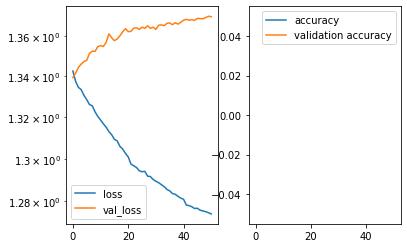

Epoch 00051: early stopping
Val Accuracy 0.3191489279270172
Test Accuracy 0.21444694697856903


In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 5*1e-4)
model.compile(loss = 'sparse_categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(X_lstm_tv, y_train_valid, test_size=0.2)
model.fit(X_train,y_train, batch_size = 32, epochs =300, validation_data = (X_val,y_val), callbacks=callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(Xred_lstm_test,y_test, verbose = 0)
print('Test Accuracy', score[1])

**Attempt**: Try taking the internal state at each 10'th timestep as feature s for the next layer.

In [ ]:
reg = regularizers.l1_l2(l1=0.0005, l2=0.0005)
inputs = tf.keras.Input(shape=(1000,22))

out1, state_h, state_c = layers.LSTM(10,return_sequences = True, return_state=True,kernel_regularizer= reg,recurrent_regularizer= reg, dropout = 0.2, name="LSTM1")(inputs)
out1 = out1[:,::10,:]

state = [state_h, state_c]
out2 = layers.LSTM(10,kernel_regularizer= reg,recurrent_regularizer= reg, name="LSTM2")(
    out1)

out3 = layers.Dense(50,kernel_regularizer= reg, activation = 'relu')(out2)
#out4 = layers.Dense(10, activation = 'relu')(out2)
out4 = layers.Dense(4,kernel_regularizer= reg, activation = 'softmax')(out3)

model = tf.keras.Model(inputs, out4)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000, 22)]        0         
_________________________________________________________________
LSTM1 (LSTM)                 [(None, 1000, 10), (None, 1320      
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 100, 10)           0         
_________________________________________________________________
LSTM2 (LSTM)                 (None, 10)                840       
_________________________________________________________________
dense (Dense)                (None, 50)                550       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 204       
Total params: 2,914
Trainable params: 2,914
Non-trainable params: 0
___________________________________________________________

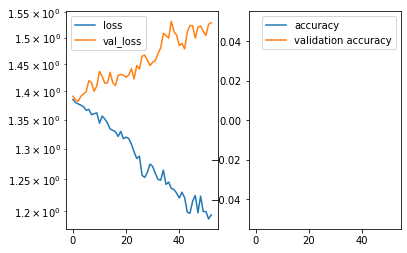

Epoch 00053: early stopping
Val Accuracy 0.28605201840400696
Test Accuracy 0.2753950357437134


In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 1e-2)
model.compile(loss = 'sparse_categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy', "sparse_categorical_accuracy"])

X_train, X_val, y_train, y_val = train_test_split(X_lstm_tv, y_train_valid, test_size=0.2)
model.fit(X_train,y_train, batch_size = 64, epochs =200, validation_data = (X_val,y_val), callbacks=callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(Xred_lstm_test,y_test, verbose = 0)
print('Test Accuracy', score[1])

**Attempt**: Return sequences from first LSTM and use every 10th sequence in second LSTM

In [ ]:
inputs = tf.keras.Input(shape=(1000,22))

out1, state_h, state_c = layers.LSTM(22,return_sequences = True, return_state=True, dropout = 0.2, name="LSTM1")(inputs)
#out1: None,1000,22
state = [state_h, state_c]

out2 = layers.LSTM(10, return_sequences=True, name="LSTM2")(out1)#out2: None, 1000,10
out2b = out2[:,::10,:] #out2b: None, 100,10

out2c = tf.expand_dims(out2b, -1) #out2c: None,100,10,1
out3 = layers.Conv2D(filters = 40, kernel_size = (5,5), padding = "same", activation = 'elu')(out2c) #out3:None,100,10,40
out4 = layers.MaxPool2D(pool_size = (4,1),strides = (2,1))(out3) #out4: None, 48+1,10, 40
out5 = layers.BatchNormalization()(out4) #out5: None, 48+1,10, 40
out6 = layers.Dropout(0.5)(out5) #out6: None, 48+1,10, 40

out7 = layers.Conv2D(filters = 80, kernel_size = (7,7), strides = (3,1), activation = 'elu')(out6) #out7: None,13,1,80
out8 = layers.BatchNormalization()(out7) #out5: None, 48+1,10, 40
out9 = layers.Dropout(0.5)(out8) #out6: None, 48+1,10, 40

out10 = layers.Flatten()(out9) #out8:None,13*1*80

out11 = layers.Dense(4, activation = 'softmax')(out10)

model = tf.keras.Model(inputs, out11)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000, 22)]        0         
_________________________________________________________________
LSTM1 (LSTM)                 [(None, 1000, 22), (None, 3960      
_________________________________________________________________
LSTM2 (LSTM)                 (None, 1000, 10)          1320      
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 100, 10)           0         
_________________________________________________________________
tf.expand_dims (TFOpLambda)  (None, 100, 10, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 10, 40)       1040      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 10, 40)        0     

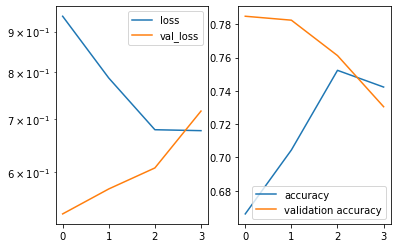

Val Accuracy 0.7304964661598206
Test Accuracy 0.4762979745864868


In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(X_lstm_tv, y_tv_onehot, test_size=0.2)
history = model.fit(X_train,y_train, batch_size = 64, epochs =4, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(Xred_lstm_test,y_test_onehot, verbose = 0)
print('Test Accuracy', score[1])

With regularization

In [ ]:
reg = regularizers.l1_l2(l1=0.1, l2=0.1)
inputs = tf.keras.Input(shape=(1000,22))

out1, state_h, state_c = layers.LSTM(22,return_sequences = True, kernel_regularizer= reg,recurrent_regularizer= reg, return_state=True, dropout = 0.2, name="LSTM1")(inputs)
#out1: None,1000,22
state = [state_h, state_c]

out2 = layers.LSTM(10, return_sequences=True,kernel_regularizer= reg,recurrent_regularizer= reg, name="LSTM2")(out1)#out2: None, 1000,10
out2b = out2[:,::10,:] #out2b: None, 100,10

out2c = tf.expand_dims(out2b, -1) #out2c: None,100,10,1
out3 = layers.Conv2D(filters = 40, kernel_size = (5,5),kernel_regularizer= reg, padding = "same", activation = 'elu')(out2c) #out3:None,100,10,40
out4 = layers.MaxPool2D(pool_size = (4,1),strides = (2,1))(out3) #out4: None, 48+1,10, 40
out5 = layers.BatchNormalization()(out4) #out5: None, 48+1,10, 40
out6 = layers.Dropout(0.5)(out5) #out6: None, 48+1,10, 40

out7 = layers.Conv2D(filters = 80, kernel_size = (7,7),kernel_regularizer= reg, strides = (3,1), activation = 'elu')(out6) #out7: None,13,1,80
out8 = layers.BatchNormalization()(out7) #out5: None, 48+1,10, 40
out9 = layers.Dropout(0.5)(out8) #out6: None, 48+1,10, 40

out10 = layers.Flatten()(out9) #out8:None,13*1*80

out11 = layers.Dense(4, activation = 'softmax')(out10)

model = tf.keras.Model(inputs, out11)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000, 22)]        0         
_________________________________________________________________
LSTM1 (LSTM)                 [(None, 1000, 22), (None, 3960      
_________________________________________________________________
LSTM2 (LSTM)                 (None, 1000, 10)          1320      
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 100, 10)           0         
_________________________________________________________________
tf.expand_dims (TFOpLambda)  (None, 100, 10, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 10, 40)       1040      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 10, 40)        0     

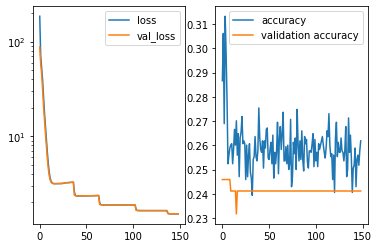

Epoch 150/250
27/27 [==============================] - 2s 74ms/step - loss: 1.5111 - accuracy: 0.2525 - val_loss: 1.5149 - val_accuracy: 0.2411


KeyboardInterrupt: ignored

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(X_lstm_tv, y_tv_onehot, test_size=0.2)
c_callbacks = get_cb("lstm2_Der_e100")
history = model.fit(X_train,y_train, batch_size = 64, epochs = 250, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(X_lstm_test,y_test_onehot, verbose = 0)
print('Test Accuracy', score[1])

Loss_big_img(history)


Force stopped because validation accuracy was not improving.

**Attempt**: Grouping the 1000 sequences into 250 sequences, pass through LSTM layers and merging the four outputs from these LSTM layers.

### LSTM-2

In [ ]:
inputs = tf.keras.Input(shape=(1000,22))
X_1 = inputs[:,0:250,:]
X_2 = inputs[:,250:500,:]
X_3 = inputs[:,500:750,:]
X_4 = inputs[:,750:1000,:]

out1a, state_h1a, state_c1a = layers.LSTM(15, return_state=True, name="LSTM1a")(X_1)#out1a: None,15
state1a = [state_h1a, state_c1a]

out1b, state_h1b, state_c1b = layers.LSTM(15, return_state=True, name="LSTM1b")(X_2, initial_state = state1a)#out1b: None,15
state1b = [state_h1b, state_c1b]

out1c, state_h1c, state_c1c = layers.LSTM(15, return_state=True, name="LSTM1c")(X_3, initial_state = state1b)#out1c: None,15
state1c = [state_h1c, state_c1c]

out1d = layers.LSTM(15, name="LSTM1d")(X_4, initial_state = state1c)#out1d: None,15

out2a = layers.Concatenate(axis = -1)([out1a, out1b, out1c, out1d]) #out2: None, 15,4
print(out2a.shape)
out2 = layers.Reshape((15,4))(out2a)
#out3 = layers.Reshape((15,4,1))(out2) #out3: None, 15,4,1
out3 = tf.expand_dims(out2, -1)#out3: None, 15,4,1
print(out3.shape)
out4 = layers.Conv2D(filters = 40, kernel_size = (3,3), padding = "same", activation = 'elu')(out3) #out4:None,15,4,40
out5 = layers.BatchNormalization()(out4) #out5: None, 15,4, 40
out6 = layers.Dropout(0.5)(out5) #out6: None, 15,4, 40

out7 = layers.Conv2D(filters = 80, kernel_size = (3,3), padding = "same", activation = 'relu')(out6) #out7:None,15,4,80
out8 = layers.BatchNormalization()(out7) #out8: None, 15,4, 80
out9 = layers.Dropout(0.5)(out8) #out9: None, 15,4, 80

out10 = layers.AveragePooling2D(pool_size = (5,2),strides = (1,1))(out9) #out9: None, 10+1,3, 80

out11 = layers.Flatten()(out10) #out11:None,11*3*80

out12 = layers.Dense(4, activation = 'softmax')(out11)
#sparse_categorical_crossentropy

model = tf.keras.Model(inputs, out12)
model.summary()

(None, 60)
(None, 15, 4, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000, 22)]   0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 250, 22)      0           input_1[0][0]                    
__________________________________________________________________________________________________
LSTM1a (LSTM)                   [(None, 15), (None,  2280        tf.__operators__.getitem[0][0]   
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 250, 22)      0           input_1[0][0]                    
__________________________________________________________________

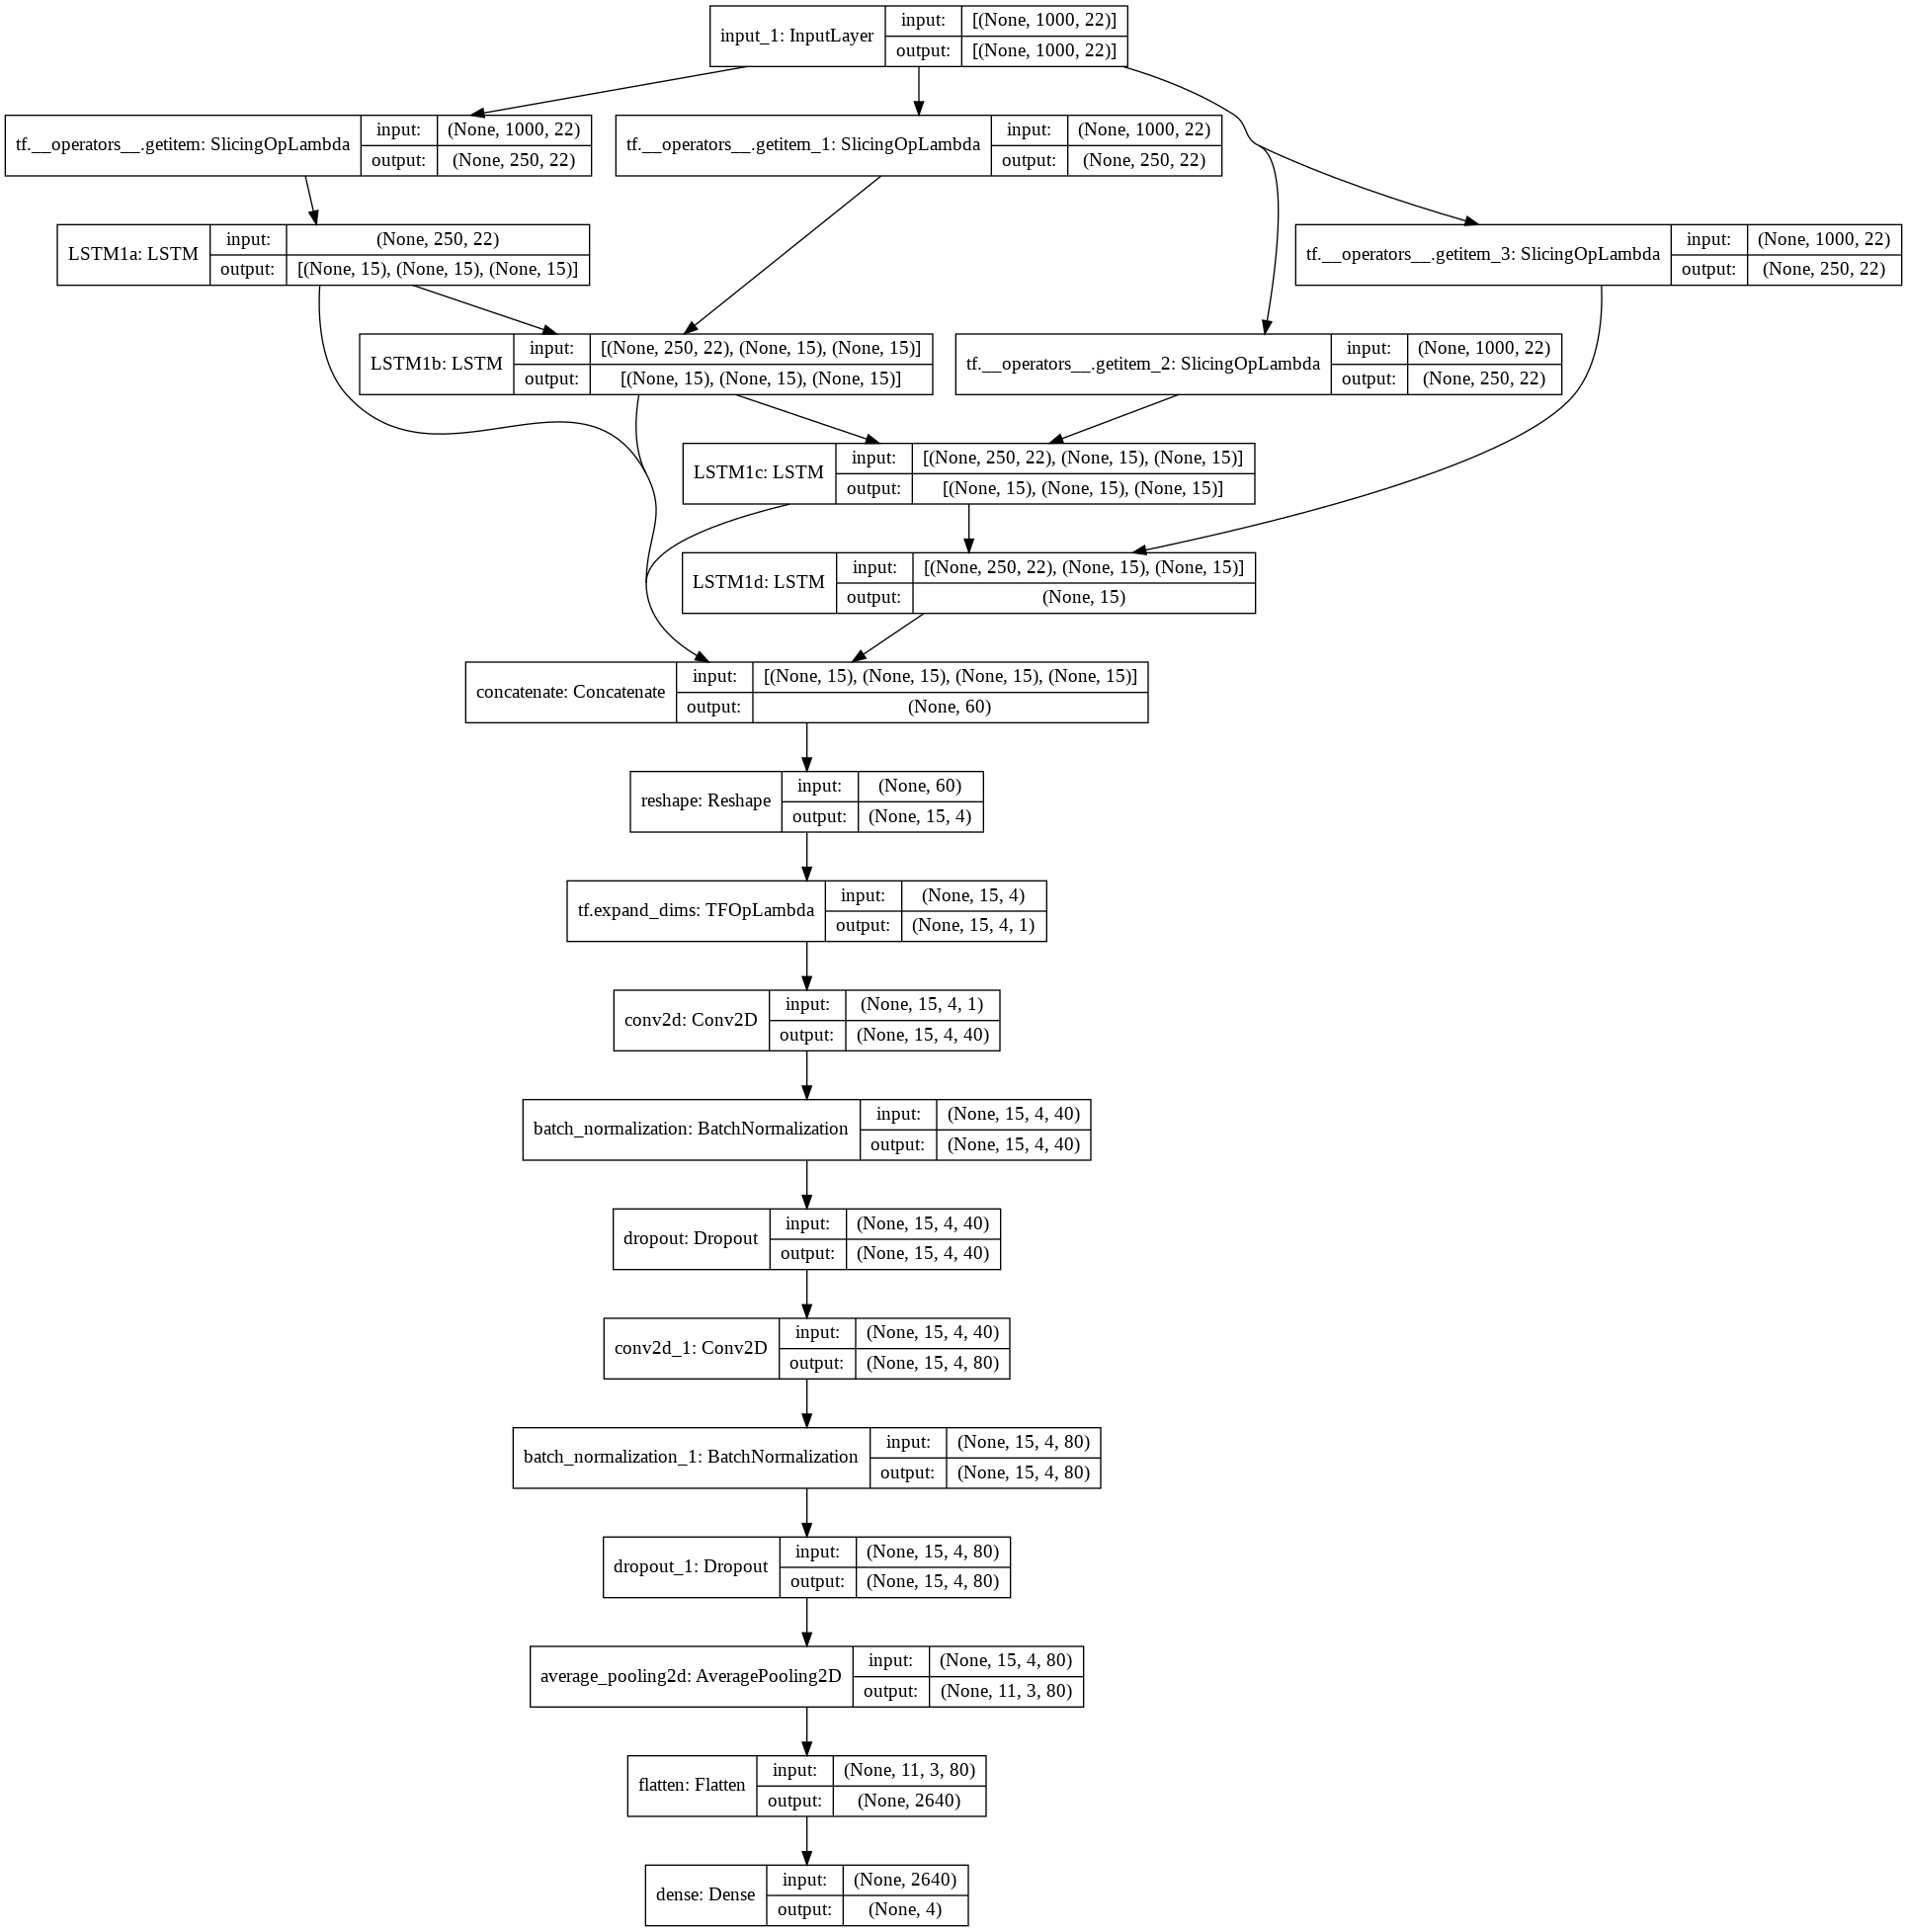

In [ ]:
plot_model(model, "LSTM-2.png", show_shapes=True)

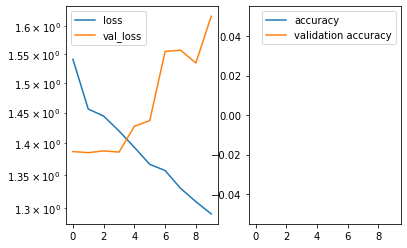

Val Accuracy 0.22695034742355347
Test Accuracy 0.284424364566803


In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
model.compile(loss = 'sparse_categorical_crossentropy',optimizer = optimizer, metrics = ['sparse_categorical_accuracy'])

X_train, X_val, y_train, y_val = train_test_split(X_lstm_tv, y_train_valid, test_size=0.2)
history = model.fit(X_train,y_train, batch_size = 64, epochs = 10, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(X_lstm_test,y_test, verbose = 0)
print('Test Accuracy', score[1])

Apply regularization to this:

reg = regularizers.l1_l2(l1=0.05, l2=0.05)

In [ ]:
reg = regularizers.l1_l2(l1=0.1, l2=0.1)
inputs = tf.keras.Input(shape=(1000,22))
X_1 = inputs[:,0:250,:]
X_2 = inputs[:,250:500,:]
X_3 = inputs[:,500:750,:]
X_4 = inputs[:,750:1000,:]

out1a, state_h1a, state_c1a = layers.LSTM(15,kernel_regularizer= reg,recurrent_regularizer= reg, return_state=True, name="LSTM1a")(X_1)#out1a: None,15
state1a = [state_h1a, state_c1a]

out1b, state_h1b, state_c1b = layers.LSTM(15,kernel_regularizer= reg,recurrent_regularizer= reg, return_state=True, name="LSTM1b")(X_2, initial_state = state1a)#out1b: None,15
state1b = [state_h1b, state_c1b]

out1c, state_h1c, state_c1c = layers.LSTM(15,kernel_regularizer= reg,recurrent_regularizer= reg, return_state=True, name="LSTM1c")(X_3, initial_state = state1b)#out1c: None,15
state1c = [state_h1c, state_c1c]

out1d = layers.LSTM(15,kernel_regularizer= reg,recurrent_regularizer= reg, name="LSTM1d")(X_4, initial_state = state1c)#out1d: None,15

out2a = layers.Concatenate(axis = -1)([out1a, out1b, out1c, out1d]) #out2: None, 15,4

out2 = layers.Reshape((15,4))(out2a)
#out3 = layers.Reshape((15,4,1))(out2) #out3: None, 15,4,1
out3 = tf.expand_dims(out2, -1)#out3: None, 15,4,1

out4 = layers.Conv2D(filters = 40, kernel_size = (3,3), padding = "same", activation = 'elu')(out3) #out4:None,15,4,40
out5 = layers.BatchNormalization()(out4) #out5: None, 15,4, 40
out6 = layers.Dropout(0.5)(out5) #out6: None, 15,4, 40

out7 = layers.Conv2D(filters = 80, kernel_size = (3,3), padding = "same", activation = 'elu')(out6) #out7:None,15,4,80
out8 = layers.BatchNormalization()(out7) #out8: None, 15,4, 80
out9 = layers.Dropout(0.5)(out8) #out9: None, 15,4, 80

out10 = layers.AveragePooling2D(pool_size = (5,2),strides = (1,1))(out9) #out9: None, 10+1,3, 80

out11 = layers.Flatten()(out10) #out11:None,11*3*80

out12 = layers.Dense(4, activation = 'softmax')(out11)
#sparse_categorical_crossentropy

model = tf.keras.Model(inputs, out12)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1000, 22)]   0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 250, 22)      0           input_7[0][0]                    
__________________________________________________________________________________________________
LSTM1a (LSTM)                   [(None, 15), (None,  2280        tf.__operators__.getitem_1[0][0] 
__________________________________________________________________________________________________
tf.__operators__.getitem_2 (Sli (None, 250, 22)      0           input_7[0][0]                    
____________________________________________________________________________________________

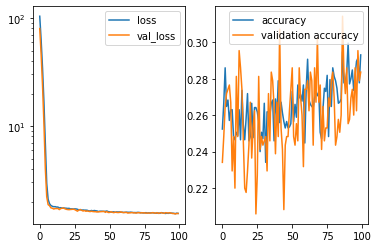

Val Accuracy 0.283687949180603
Test Accuracy 0.2663656771183014


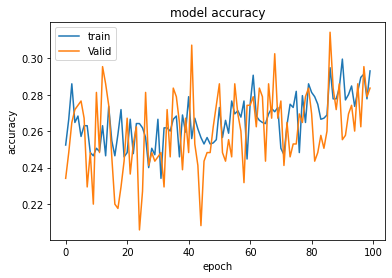

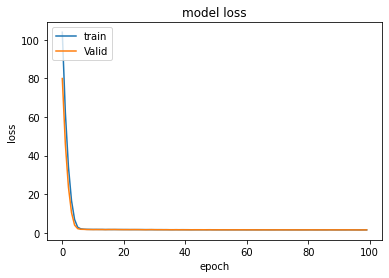

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
model.compile(loss = 'sparse_categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(Xred_lstm_tv, y_train_valid, test_size=0.2)
c_callbacks = get_cb("seq_ip_red_reg_e250")
history = model.fit(X_train,y_train, batch_size = 32, epochs = 100, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(Xred_lstm_test,y_test, verbose = 0)
print('Test Accuracy', score[1])

Loss_big_img(history)

**Attempt**: Passing the data through an LSTM and sending the final state as the input to the next layer.

In [ ]:
inputs = tf.keras.Input(shape=(1000,22))

out1 = layers.LSTM(22, name="LSTM1")(inputs)#out1: None,22

out2 = layers.Dense(32, activation = 'relu',)(out1)#out2: None,32
out3 = layers.BatchNormalization()(out2) #out3: None, 32
out4 = layers.Dropout(0.5)(out3) #out4: None, 32

out5 = layers.Dense(64, activation = 'relu')(out4)#out5: None, 64
out6 = layers.BatchNormalization()(out5) #out6: None, 64
out7 = layers.Dropout(0.6)(out6) #out4: None, 64

out8 = layers.Dense(32, activation = 'relu',)(out7)#out8: None,32
out9 = layers.BatchNormalization()(out8) #out9: None, 32
out10 = layers.Dropout(0.5)(out9) #out10: None, 32

out11 = layers.Dense(4, activation = 'softmax')(out10)
#sparse_categorical_crossentropy

model = tf.keras.Model(inputs, out11)
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 1000, 22)]        0         
_________________________________________________________________
LSTM1 (LSTM)                 (None, 22)                3960      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                736       
_________________________________________________________________
batch_normalization_16 (Batc (None, 32)                128       
_________________________________________________________________
dropout_15 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_17 (Batc (None, 64)                256 

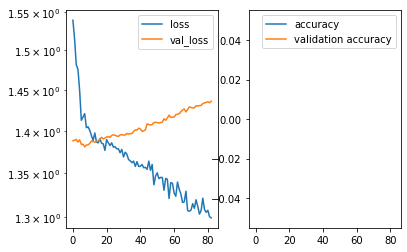

Epoch 00083: early stopping
Val Accuracy 0.29078012704849243
Test Accuracy 0.18735891580581665


In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['categorical_accuracy'])

X_train, X_val, y_train, y_val = train_test_split(X_lstm_tv, y_tv_onehot, test_size=0.2)
history = model.fit(X_train,y_train, batch_size = 32, epochs = 350, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(X_lstm_test,y_test_onehot, verbose = 0)
print('Test Accuracy', score[1])

**Attempt**: Using ConvLSTM2D

ConvLSTM

In [ ]:
seq = tf.keras.Sequential(
    [
        tf.keras.Input(
            shape=(1000, 6, 7, 1)
        ),  # Variable-length sequence of 40x40x1 frames
        layers.ConvLSTM2D(
            filters=30, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=30, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        #layers.ConvLSTM2D(
        #    filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        #),
        #layers.BatchNormalization(),
        #layers.ConvLSTM2D(
        #    filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        #),
        #layers.BatchNormalization(),
        layers.Conv3D(
            filters=1, kernel_size=(3, 3, 3), activation="relu", padding="same"
        ),
        
        layers.MaxPooling3D(pool_size=(10,2,1), strides = (2,1,1)),

        layers.Flatten(),
     
        layers.Dense(4, activation="softmax"),
    ]
)
seq.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 1000, 6, 7, 30)    33600     
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000, 6, 7, 30)    120       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 1000, 6, 7, 30)    64920     
_________________________________________________________________
batch_normalization_3 (Batch (None, 1000, 6, 7, 30)    120       
_________________________________________________________________
conv3d (Conv3D)              (None, 1000, 6, 7, 1)     811       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 496, 5, 7, 1)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 17360)             0

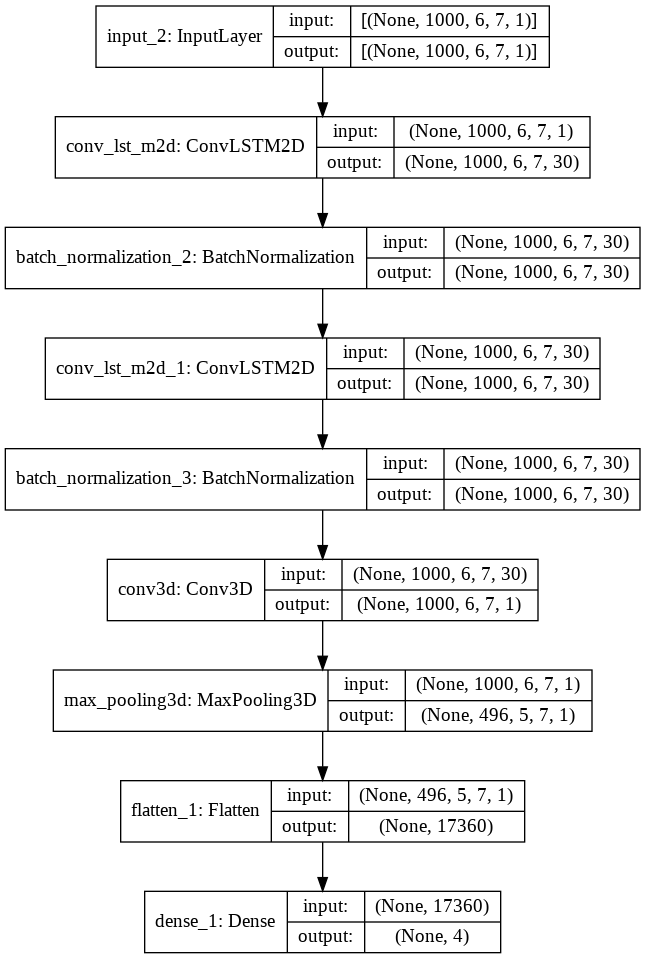

In [ ]:
plot_model(seq, "ConvLSTM.png", show_shapes=True)

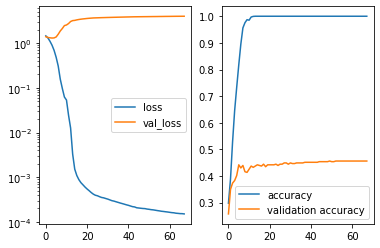

Epoch 69/350
14/27 [==============>...............] - ETA: 2:15 - loss: 1.4511e-04 - accuracy: 1.0000

KeyboardInterrupt: ignored

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
seq.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(new_lstm_tv, y_tv_onehot, test_size=0.2)
history = seq.fit(X_train,y_train, batch_size = 64, epochs = 350, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = seq.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = seq.evaluate(new_lstm_test,y_test_onehot, verbose = 0)
print('Test Accuracy', score[1])

**KEY ATTEMPT**:

One LSTM at the start and then the best performing CNN architecture.

It was decided to try **6 units** for the state dimension in the LSTM layer. This is because a 6 rank approximation could very closely approximate all given input trials.

In [ ]:
inputs = tf.keras.Input(shape=(1000,22))

out1 = layers.LSTM(6, return_sequences=True, name="LSTM1")(inputs)#out1a: None,1000,6

out2 = tf.expand_dims(out1, 2)#out3: None, 1000,1,6

out3 = layers.Conv2D(40, (8,1), padding = 'same', activation = 'elu')(out2) #out3: None, 1000, 1, 40
out4 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out3) #out4: None, 249+1, 1, 40
out5 = layers.BatchNormalization()(out4) #out5: None, 250,1,40
out6 = layers.Dropout(0.5)(out5) #out6: None, 250, 1, 40

out7 = layers.Conv2D(filters = 160, kernel_size = (8,1), padding = 'same', activation = 'elu')(out6) #out6: None, 250, 1, 80
out8 = layers.AveragePooling2D(pool_size = (4,1),strides = (2,1))(out7) #out8: None,124, 1, 80
out9 = layers.BatchNormalization()(out8)
out10 = layers.Dropout(0.5)(out9)

out11 = layers.Conv2D(filters = 80, kernel_size = (8,1), padding = 'same', activation = 'elu')(out10) #out10: None, 124, 1, 80
out12 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out11) #out11: None,31, 1, 80
out13 = layers.BatchNormalization()(out12)
out14 = layers.Dropout(0.5)(out13)

out15 = layers.Flatten()(out14)
out16 = layers.Dense(4, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1000, 22)]        0         
_________________________________________________________________
LSTM1 (LSTM)                 (None, 1000, 6)           696       
_________________________________________________________________
tf.expand_dims_2 (TFOpLambda (None, 1000, 1, 6)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1000, 1, 40)       1960      
_________________________________________________________________
average_pooling2d_2 (Average (None, 250, 1, 40)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 250, 1, 40)        160       
_________________________________________________________________
dropout (Dropout)            (None, 250, 1, 40)        0     

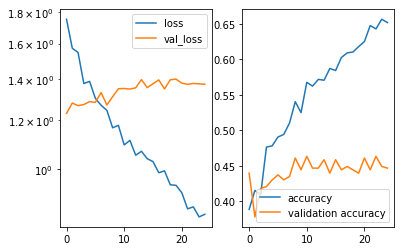

Val Accuracy 0.44680851697921753
Test Accuracy 0.46726861596107483


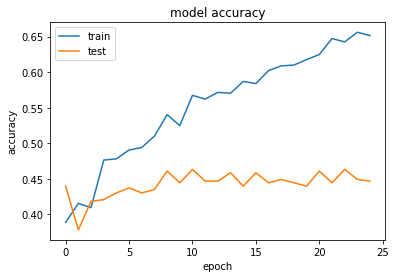

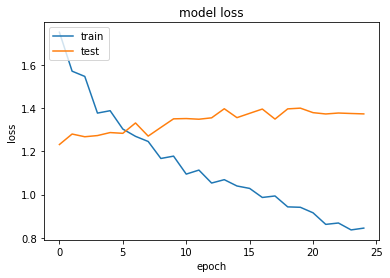

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 5e-4)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(X_lstm_tv, y_tv_onehot, test_size=0.2)
c_callbacks = get_cb("lstm_derek")
history = model.fit(X_train,y_train, batch_size = 64, epochs = 25, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(X_lstm_test,y_test_onehot, verbose = 0)
print('Test Accuracy', score[1])

Loss_big_img(history)

Notice that the test accuracy is 46%, which is higher than all the previous models.

One LSTM (6 units) then Conv. **With regularization:**

### LSTM - CNN_adaptive reg-2

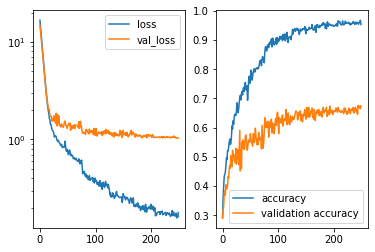

Val Accuracy 0.673758864402771
Test Accuracy 0.6546275615692139


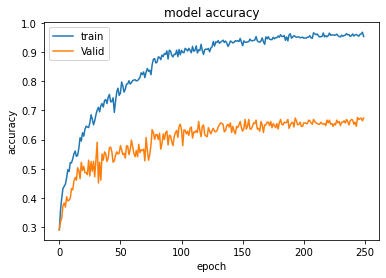

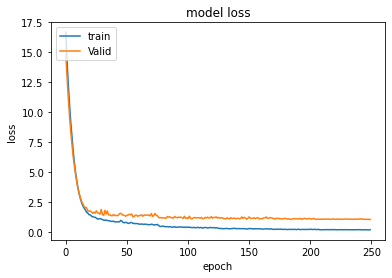

In [ ]:
reg = regularizers.l1_l2(l1=0.1, l2=0.1)

inputs = tf.keras.Input(shape=(1000,22))

out1 = layers.LSTM(6, return_sequences=True,kernel_regularizer= reg,recurrent_regularizer= reg, name="LSTM1")(inputs)#out1a: None,1000,6

out2 = tf.expand_dims(out1, 2)#out3: None, 1000,1,6

out3 = layers.Conv2D(40, (8,1), padding = 'same', activation = 'elu')(out2) #out3: None, 1000, 1, 40
out4 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out3) #out4: None, 249+1, 1, 40
out5 = layers.BatchNormalization()(out4) #out5: None, 250,1,40
out6 = layers.Dropout(0.5)(out5) #out6: None, 250, 1, 40

out7 = layers.Conv2D(filters = 160, kernel_size = (8,1), padding = 'same', activation = 'elu')(out6) #out6: None, 250, 1, 80
out8 = layers.AveragePooling2D(pool_size = (4,1),strides = (2,1))(out7) #out8: None,124, 1, 80
out9 = layers.BatchNormalization()(out8)
out10 = layers.Dropout(0.5)(out9)

out11 = layers.Conv2D(filters = 80, kernel_size = (8,1), padding = 'same', activation = 'elu')(out10) #out10: None, 124, 1, 80
out12 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out11) #out11: None,31, 1, 80
out13 = layers.BatchNormalization()(out12)
out14 = layers.Dropout(0.5)(out13)

out15 = layers.Flatten()(out14)
out16 = layers.Dense(4, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)
#model.summary()

optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(X_lstm_tv, y_tv_onehot, test_size=0.2)
c_callbacks = get_cb("lstm_Der_6_l12_e250")
history = model.fit(X_train,y_train, batch_size = 64, epochs = 250, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(X_lstm_test,y_test_onehot, verbose = 0)
print('Test Accuracy', score[1])

Loss_big_img(history)


In [ ]:
#@title
reg = regularizers.l1_l2(l1=0.1, l2=0.1)

inputs = tf.keras.Input(shape=(1000,22))

out1 = layers.LSTM(6, return_sequences=True,kernel_regularizer= reg,recurrent_regularizer= reg, name="LSTM1")(inputs)#out1a: None,1000,6

out2 = tf.expand_dims(out1, 2)#out3: None, 1000,1,6

out3 = layers.Conv2D(40, (8,1), padding = 'same', activation = 'elu')(out2) #out3: None, 1000, 1, 40
out4 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out3) #out4: None, 249+1, 1, 40
out5 = layers.BatchNormalization()(out4) #out5: None, 250,1,40
out6 = layers.Dropout(0.5)(out5) #out6: None, 250, 1, 40

out7 = layers.Conv2D(filters = 160, kernel_size = (8,1), padding = 'same', activation = 'elu')(out6) #out6: None, 250, 1, 80
out8 = layers.AveragePooling2D(pool_size = (4,1),strides = (2,1))(out7) #out8: None,124, 1, 80
out9 = layers.BatchNormalization()(out8)
out10 = layers.Dropout(0.5)(out9)

out11 = layers.Conv2D(filters = 80, kernel_size = (8,1), padding = 'same', activation = 'elu')(out10) #out10: None, 124, 1, 80
out12 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out11) #out11: None,31, 1, 80
out13 = layers.BatchNormalization()(out12)
out14 = layers.Dropout(0.5)(out13)

out15 = layers.Flatten()(out14)
out16 = layers.Dense(4, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1000, 22)]        0         
_________________________________________________________________
LSTM1 (LSTM)                 (None, 1000, 6)           696       
_________________________________________________________________
tf.expand_dims_2 (TFOpLambda (None, 1000, 1, 6)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1000, 1, 40)       1960      
_________________________________________________________________
average_pooling2d_4 (Average (None, 250, 1, 40)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 250, 1, 40)        160       
_________________________________________________________________
dropout_5 (Dropout)          (None, 250, 1, 40)        0   

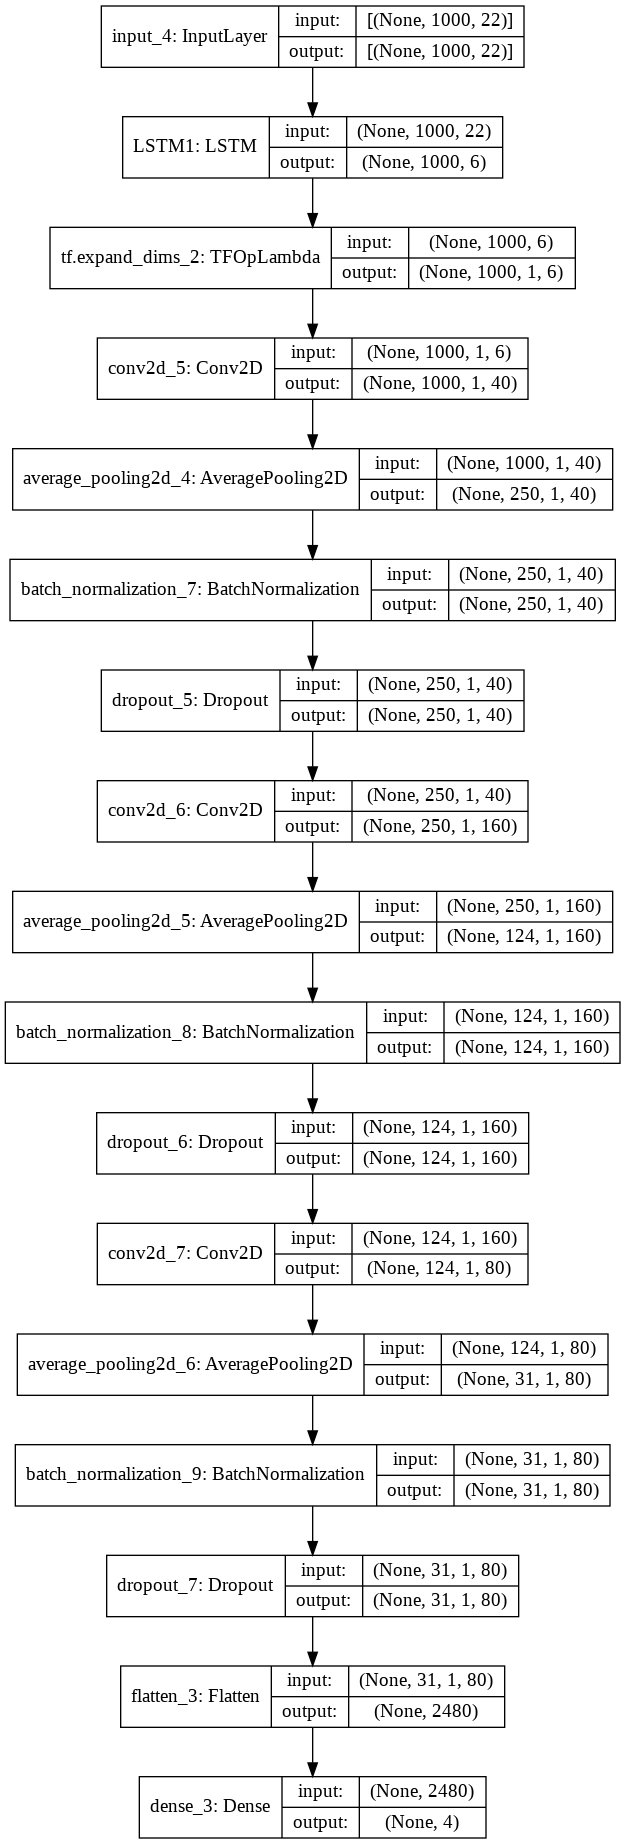

In [ ]:
plot_model(model,"LSTM - CNN_adaptive reg-2.png", show_shapes = True)

**Key observation:**

A test accuracy of 65% was obtained. This is our best model with an LSTM at the start. Regularization at the first layer helped.

**Attempt** LSTM, 6 units, lowering regularization in later layers.

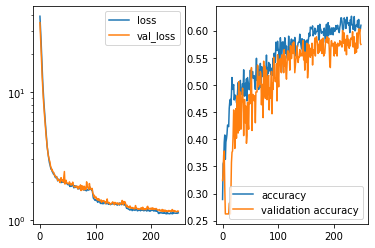

Val Accuracy 0.5744680762290955
Test Accuracy 0.5869074463844299


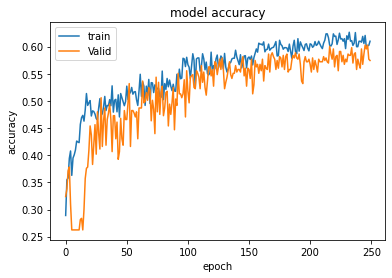

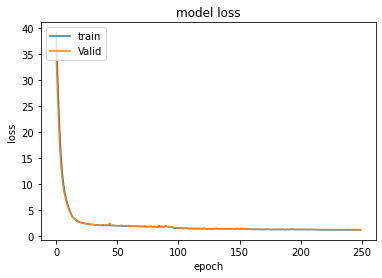

In [ ]:
reg1 = regularizers.l1_l2(l1=0.1, l2=0.1)
reg2 = regularizers.l1_l2(l1=0.005, l2=0.005)
inputs = tf.keras.Input(shape=(1000,22))

out1 = layers.LSTM(6, return_sequences=True,kernel_regularizer= reg1,recurrent_regularizer= reg1, name="LSTM1")(inputs)#out1a: None,1000,6

out2 = tf.expand_dims(out1, 2)#out3: None, 1000,1,6

out3 = layers.Conv2D(40, (8,1), padding = 'same',kernel_regularizer= reg2, activation = 'elu')(out2) #out3: None, 1000, 1, 40
out4 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out3) #out4: None, 249+1, 1, 40
out5 = layers.BatchNormalization()(out4) #out5: None, 250,1,40
out6 = layers.Dropout(0.5)(out5) #out6: None, 250, 1, 40

out7 = layers.Conv2D(filters = 160, kernel_size = (8,1),kernel_regularizer= reg2, padding = 'same', activation = 'elu')(out6) #out6: None, 250, 1, 80
out8 = layers.AveragePooling2D(pool_size = (4,1),strides = (2,1))(out7) #out8: None,124, 1, 80
out9 = layers.BatchNormalization()(out8)
out10 = layers.Dropout(0.5)(out9)

out11 = layers.Conv2D(filters = 80, kernel_size = (8,1),kernel_regularizer= reg2, padding = 'same', activation = 'elu')(out10) #out10: None, 124, 1, 80
out12 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out11) #out11: None,31, 1, 80
out13 = layers.BatchNormalization()(out12)
out14 = layers.Dropout(0.5)(out13)

out15 = layers.Flatten()(out14)
out16 = layers.Dense(4,kernel_regularizer= reg2, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)
#model.summary()

optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(X_lstm_tv, y_tv_onehot, test_size=0.2)
c_callbacks = get_cb("lstm_Der_6_changingReg_e250")
history = model.fit(X_train,y_train, batch_size = 64, epochs = 250, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(X_lstm_test,y_test_onehot, verbose = 0)
print('Test Accuracy', score[1])

Loss_big_img(history)

More epochs

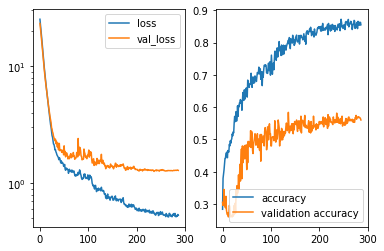

Epoch 00287: early stopping
Val Accuracy 0.5602836608886719
Test Accuracy 0.5936794877052307


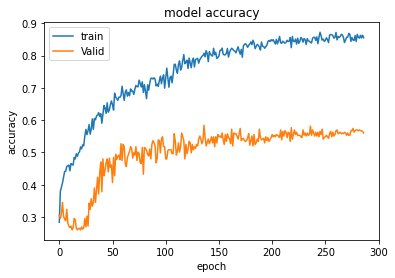

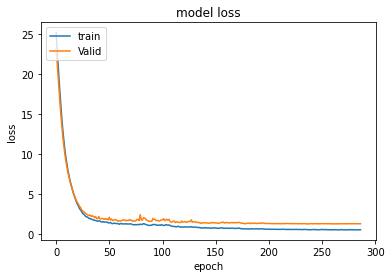

In [ ]:
reg1 = regularizers.l1_l2(l1=0.1, l2=0.1)
reg2 = regularizers.l1_l2(l1=0.005, l2=0.005)
inputs = tf.keras.Input(shape=(1000,22))

out1 = layers.LSTM(6, return_sequences=True,kernel_regularizer= reg1,recurrent_regularizer= reg1, name="LSTM1")(inputs)#out1a: None,1000,6

out2 = tf.expand_dims(out1, 2)#out3: None, 1000,1,6

out3 = layers.Conv2D(40, (8,1), padding = 'same',kernel_regularizer= reg2, activation = 'elu')(out2) #out3: None, 1000, 1, 40
out4 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out3) #out4: None, 249+1, 1, 40
out5 = layers.BatchNormalization()(out4) #out5: None, 250,1,40
out6 = layers.Dropout(0.5)(out5) #out6: None, 250, 1, 40

out7 = layers.Conv2D(filters = 160, kernel_size = (8,1),kernel_regularizer= reg2, padding = 'same', activation = 'elu')(out6) #out6: None, 250, 1, 80
out8 = layers.AveragePooling2D(pool_size = (4,1),strides = (2,1))(out7) #out8: None,124, 1, 80
out9 = layers.BatchNormalization()(out8)
out10 = layers.Dropout(0.5)(out9)

out11 = layers.Conv2D(filters = 80, kernel_size = (8,1), padding = 'same', activation = 'elu')(out10) #out10: None, 124, 1, 80
out12 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out11) #out11: None,31, 1, 80
out13 = layers.BatchNormalization()(out12)
out14 = layers.Dropout(0.5)(out13)

out15 = layers.Flatten()(out14)
out16 = layers.Dense(4, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)
#model.summary()

optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(X_lstm_tv, y_tv_onehot, test_size=0.2)
c_callbacks = get_cb("lstm_Der_6_changingReg_e450")
history = model.fit(X_train,y_train, batch_size = 128, epochs = 450, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(X_lstm_test,y_test_onehot, verbose = 0)
print('Test Accuracy', score[1])

Loss_big_img(history)

**Attempt** Same with more units in LSTM

### LSTM - CNN_adaptive reg-3

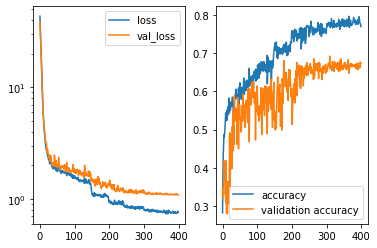

Val Accuracy 0.6761229038238525
Test Accuracy 0.6297968626022339


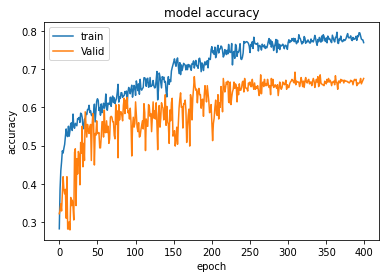

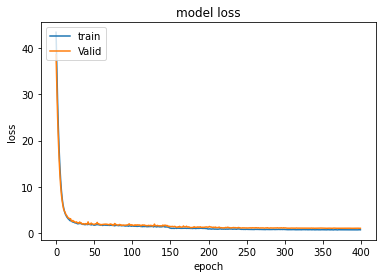

In [ ]:
reg1 = regularizers.l1_l2(l1=0.1, l2=0.1)
reg2 = regularizers.l1_l2(l1=0.005, l2=0.005)
reg3 = regularizers.l1_l2(l1=0.001, l2=0.001)
inputs = tf.keras.Input(shape=(1000,22))

out1 = layers.LSTM(15, return_sequences=True,kernel_regularizer= reg1,recurrent_regularizer= reg1, name="LSTM1")(inputs)#out1a: None,1000,15

out2 = tf.expand_dims(out1, 2)#out3: None, 1000,1,15

out3 = layers.Conv2D(40, (8,1), padding = 'same',kernel_regularizer= reg2, activation = 'elu')(out2) #out3: None, 1000, 1, 40
out4 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out3) #out4: None, 249+1, 1, 40
out5 = layers.BatchNormalization()(out4) #out5: None, 250,1,40
out6 = layers.Dropout(0.5)(out5) #out6: None, 250, 1, 40

out7 = layers.Conv2D(filters = 160, kernel_size = (8,1),kernel_regularizer= reg2, padding = 'same', activation = 'elu')(out6) #out6: None, 250, 1, 80
out8 = layers.AveragePooling2D(pool_size = (4,1),strides = (2,1))(out7) #out8: None,124, 1, 80
out9 = layers.BatchNormalization()(out8)
out10 = layers.Dropout(0.5)(out9)

out11 = layers.Conv2D(filters = 80, kernel_size = (8,1),kernel_regularizer= reg3, padding = 'same', activation = 'elu')(out10) #out10: None, 124, 1, 80
out12 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out11) #out11: None,31, 1, 80
out13 = layers.BatchNormalization()(out12)
out14 = layers.Dropout(0.5)(out13)

out15 = layers.Flatten()(out14)
out16 = layers.Dense(4, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)
#model.summary()

optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(X_lstm_tv, y_tv_onehot, test_size=0.2)
c_callbacks = get_cb("lstm_Der_15_changingReg_e450")
history = model.fit(X_train,y_train, batch_size = 64, epochs = 400, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(X_lstm_test,y_test_onehot, verbose = 0)
print('Test Accuracy', score[1])

Loss_big_img(history)

In [ ]:
#@title
inputs = tf.keras.Input(shape=(1000,22))

out1 = layers.LSTM(15, return_sequences=True,kernel_regularizer= reg1,recurrent_regularizer= reg1, name="LSTM1")(inputs)#out1a: None,1000,15

out2 = tf.expand_dims(out1, 2)#out3: None, 1000,1,15

out3 = layers.Conv2D(40, (8,1), padding = 'same',kernel_regularizer= reg2, activation = 'elu')(out2) #out3: None, 1000, 1, 40
out4 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out3) #out4: None, 249+1, 1, 40
out5 = layers.BatchNormalization()(out4) #out5: None, 250,1,40
out6 = layers.Dropout(0.5)(out5) #out6: None, 250, 1, 40

out7 = layers.Conv2D(filters = 160, kernel_size = (8,1),kernel_regularizer= reg2, padding = 'same', activation = 'elu')(out6) #out6: None, 250, 1, 80
out8 = layers.AveragePooling2D(pool_size = (4,1),strides = (2,1))(out7) #out8: None,124, 1, 80
out9 = layers.BatchNormalization()(out8)
out10 = layers.Dropout(0.5)(out9)

out11 = layers.Conv2D(filters = 80, kernel_size = (8,1),kernel_regularizer= reg3, padding = 'same', activation = 'elu')(out10) #out10: None, 124, 1, 80
out12 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out11) #out11: None,31, 1, 80
out13 = layers.BatchNormalization()(out12)
out14 = layers.Dropout(0.5)(out13)

out15 = layers.Flatten()(out14)
out16 = layers.Dense(4, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1000, 22)]        0         
_________________________________________________________________
LSTM1 (LSTM)                 (None, 1000, 15)          2280      
_________________________________________________________________
tf.expand_dims_3 (TFOpLambda (None, 1000, 1, 15)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 1000, 1, 40)       4840      
_________________________________________________________________
average_pooling2d_7 (Average (None, 250, 1, 40)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 250, 1, 40)        160       
_________________________________________________________________
dropout_8 (Dropout)          (None, 250, 1, 40)        0   

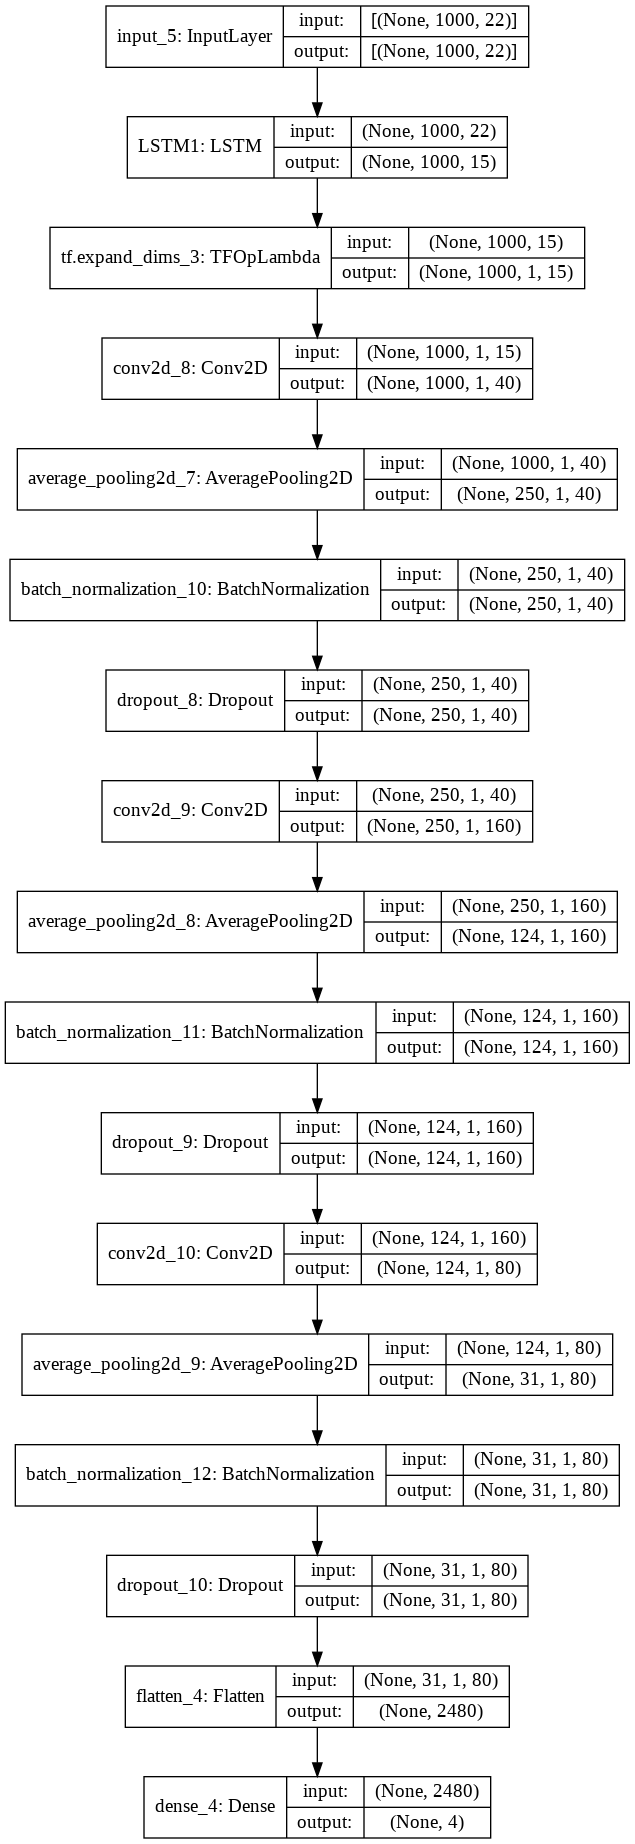

In [ ]:
plot_model(model,"LSTM - CNN_adaptive reg-3.png", show_shapes=True)

Using 15 units in the LSTM layer also gives a test accuracy of 62.9%


**Attempt** With cropped data

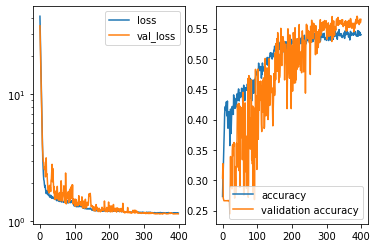

Val Accuracy 0.5650117993354797


ValueError: ignored

In [ ]:
reg1 = regularizers.l1_l2(l1=0.1, l2=0.1)
reg2 = regularizers.l1_l2(l1=0.005, l2=0.005)
reg3 = regularizers.l1_l2(l1=0.001, l2=0.001)
inputs = tf.keras.Input(shape=(800,22))

out1 = layers.LSTM(15, return_sequences=True,kernel_regularizer= reg1,recurrent_regularizer= reg1, name="LSTM1")(inputs)#out1a: None,800,15

out2 = tf.expand_dims(out1, 2)#out3: None, 800,1,15

out3 = layers.Conv2D(40, (8,1), padding = 'same',kernel_regularizer= reg2, activation = 'elu')(out2) #out3: None, 800, 1, 40
out4 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out3) #out4: None, 199+1, 1, 40
out5 = layers.BatchNormalization()(out4) #out5: None, 200,1,40
out6 = layers.Dropout(0.5)(out5) #out6: None, 200, 1, 40

out7 = layers.Conv2D(filters = 160, kernel_size = (8,1),kernel_regularizer= reg2, padding = 'same', activation = 'elu')(out6) #out6: None, 200, 1, 80
out8 = layers.AveragePooling2D(pool_size = (2,1),strides = (2,1))(out7) #out8: None,100, 1, 80
out9 = layers.BatchNormalization()(out8)
out10 = layers.Dropout(0.5)(out9)

out11 = layers.Conv2D(filters = 80, kernel_size = (8,1),kernel_regularizer= reg3, padding = 'same', activation = 'elu')(out10) #out10: None, 100, 1, 80
out12 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out11) #out11: None,25, 1, 80
out13 = layers.BatchNormalization()(out12)
out14 = layers.Dropout(0.5)(out13)

out15 = layers.Flatten()(out14)
out16 = layers.Dense(4, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)
#model.summary()

optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(Xcrop_lstm_tv, ycrop_tv_onehot, test_size=0.2)
c_callbacks = get_cb("lstm_Der_crop15_changingReg_e450")
history = model.fit(X_train,y_train, batch_size = 256, epochs = 400, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score1 = model.evaluate(Xcrop_lstm_test[0::5],y_test_onehot[0::5], verbose = 0)
print('Test Accuracy', score1[1])
score2 = model.evaluate(Xcrop_lstm_test[1::5],y_test_onehot[1::5], verbose = 0)
print('Test Accuracy', score2[1])
score3 = model.evaluate(Xcrop_lstm_test[2::5],y_test_onehot[2::5], verbose = 0)
print('Test Accuracy', score3[1])
score4 = model.evaluate(Xcrop_lstm_test[3::5],y_test_onehot[3::5], verbose = 0)
print('Test Accuracy', score4[1])
score5 = model.evaluate(Xcrop_lstm_test[4::5],y_test_onehot[4::5], verbose = 0)
print('Test Accuracy', score5[1])
Loss_big_img(history)

Test Accuracy 0.5259593725204468
Test Accuracy 0.5711060762405396
Test Accuracy 0.5665914416313171
Test Accuracy 0.53724604845047
Test Accuracy 0.471783310174942


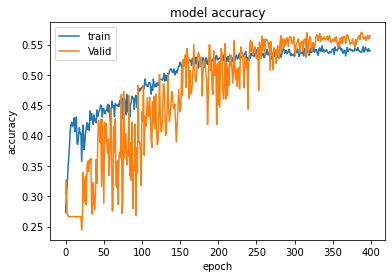

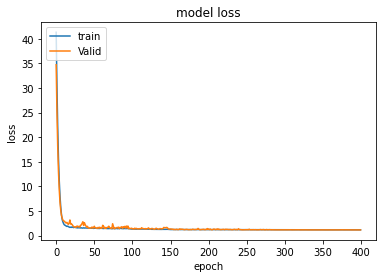

In [ ]:
score1 = model.evaluate(Xcrop_lstm_test[0::5],ycrop_test_onehot[0::5], verbose = 0)
print('Test Accuracy', score1[1])
score2 = model.evaluate(Xcrop_lstm_test[1::5],ycrop_test_onehot[1::5], verbose = 0)
print('Test Accuracy', score2[1])
score3 = model.evaluate(Xcrop_lstm_test[2::5],ycrop_test_onehot[2::5], verbose = 0)
print('Test Accuracy', score3[1])
score4 = model.evaluate(Xcrop_lstm_test[3::5],ycrop_test_onehot[3::5], verbose = 0)
print('Test Accuracy', score4[1])
score5 = model.evaluate(Xcrop_lstm_test[4::5],ycrop_test_onehot[4::5], verbose = 0)
print('Test Accuracy', score5[1])
Loss_big_img(history)

**Attempt** :With 15 units, and data de-noized by SVD

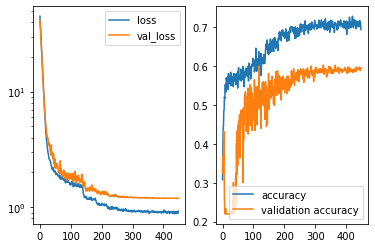

Epoch 00449: early stopping
Val Accuracy 0.5957446694374084
Test Accuracy 0.5485327243804932


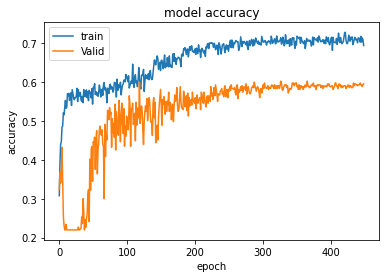

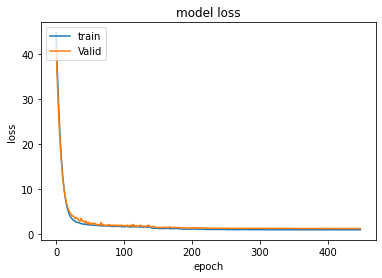

In [ ]:
reg1 = regularizers.l1_l2(l1=0.1, l2=0.1)
reg2 = regularizers.l1_l2(l1=0.005, l2=0.005)
reg3 = regularizers.l1_l2(l1=0.001, l2=0.001)
inputs = tf.keras.Input(shape=(1000,22))

out1 = layers.LSTM(15, return_sequences=True,kernel_regularizer= reg1,recurrent_regularizer= reg1, name="LSTM1")(inputs)#out1a: None,1000,15

out2 = tf.expand_dims(out1, 2)#out3: None, 1000,1,15

out3 = layers.Conv2D(40, (8,1), padding = 'same',kernel_regularizer= reg2, activation = 'elu')(out2) #out3: None, 1000, 1, 40
out4 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out3) #out4: None, 249+1, 1, 40
out5 = layers.BatchNormalization()(out4) #out5: None, 250,1,40
out6 = layers.Dropout(0.5)(out5) #out6: None, 250, 1, 40

out7 = layers.Conv2D(filters = 160, kernel_size = (8,1),kernel_regularizer= reg2, padding = 'same', activation = 'elu')(out6) #out6: None, 250, 1, 80
out8 = layers.AveragePooling2D(pool_size = (4,1),strides = (2,1))(out7) #out8: None,124, 1, 80
out9 = layers.BatchNormalization()(out8)
out10 = layers.Dropout(0.5)(out9)

out11 = layers.Conv2D(filters = 80, kernel_size = (8,1),kernel_regularizer= reg3, padding = 'same', activation = 'elu')(out10) #out10: None, 124, 1, 80
out12 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out11) #out11: None,31, 1, 80
out13 = layers.BatchNormalization()(out12)
out14 = layers.Dropout(0.5)(out13)

out15 = layers.Flatten()(out14)
out16 = layers.Dense(4, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)
#model.summary()

optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(Xred_lstm_tv, y_tv_onehot, test_size=0.2)
c_callbacks = get_cb("lstm_Der_22_red_changingReg_e450")
history = model.fit(X_train,y_train, batch_size = 128, epochs = 450, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(Xred_lstm_test,y_test_onehot, verbose = 0)
print('Test Accuracy', score[1])

Loss_big_img(history)

Did not work that great. Let us use 22 units in the LSTM.

### LSTM-CNN_adaptive reg -1

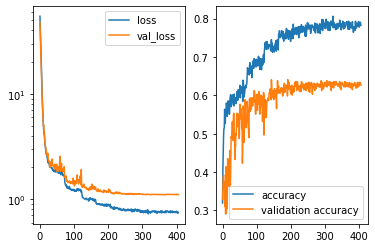

Epoch 00406: early stopping
Val Accuracy 0.6264775395393372
Test Accuracy 0.6613995432853699


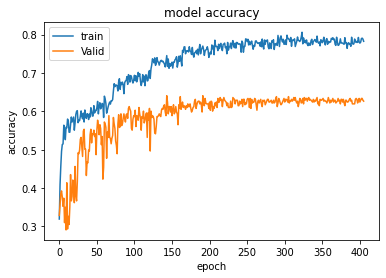

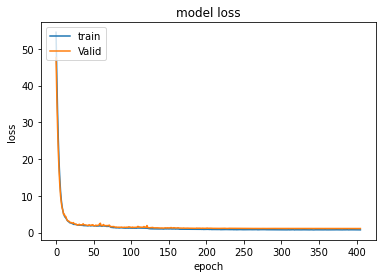

In [ ]:
reg1 = regularizers.l1_l2(l1=0.1, l2=0.1)
reg2 = regularizers.l1_l2(l1=0.005, l2=0.005)
reg3 = regularizers.l1_l2(l1=0.001, l2=0.001)
inputs = tf.keras.Input(shape=(1000,22))

out1 = layers.LSTM(22, return_sequences=True,kernel_regularizer= reg1,recurrent_regularizer= reg1, name="LSTM1")(inputs)#out1a: None,1000,22

out2 = tf.expand_dims(out1, 2)#out3: None, 1000,1,22

out3 = layers.Conv2D(40, (8,1), padding = 'same',kernel_regularizer= reg2, activation = 'elu')(out2) #out3: None, 1000, 1, 40
out4 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out3) #out4: None, 249+1, 1, 40
out5 = layers.BatchNormalization()(out4) #out5: None, 250,1,40
out6 = layers.Dropout(0.5)(out5) #out6: None, 250, 1, 40

out7 = layers.Conv2D(filters = 160, kernel_size = (8,1),kernel_regularizer= reg2, padding = 'same', activation = 'elu')(out6) #out6: None, 250, 1, 80
out8 = layers.AveragePooling2D(pool_size = (4,1),strides = (2,1))(out7) #out8: None,124, 1, 80
out9 = layers.BatchNormalization()(out8)
out10 = layers.Dropout(0.5)(out9)

out11 = layers.Conv2D(filters = 80, kernel_size = (8,1),kernel_regularizer= reg3, padding = 'same', activation = 'elu')(out10) #out10: None, 124, 1, 80
out12 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out11) #out11: None,31, 1, 80
out13 = layers.BatchNormalization()(out12)
out14 = layers.Dropout(0.5)(out13)

out15 = layers.Flatten()(out14)
out16 = layers.Dense(4, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)
model.summary()

optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(X_lstm_tv, y_tv_onehot, test_size=0.2)
c_callbacks = get_cb("lstm_Der_22_changingReg_e450")
history = model.fit(X_train,y_train, batch_size = 64, epochs = 450, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(X_lstm_test,y_test_onehot, verbose = 0)
print('Test Accuracy', score[1])

Loss_big_img(history)

In [ ]:
reg1 = regularizers.l1_l2(l1=0.1, l2=0.1)
reg2 = regularizers.l1_l2(l1=0.005, l2=0.005)
reg3 = regularizers.l1_l2(l1=0.001, l2=0.001)
inputs = tf.keras.Input(shape=(1000,22))

out1 = layers.LSTM(22, return_sequences=True,kernel_regularizer= reg1,recurrent_regularizer= reg1, name="LSTM1")(inputs)#out1a: None,1000,22

out2 = tf.expand_dims(out1, 2)#out3: None, 1000,1,22

out3 = layers.Conv2D(40, (8,1), padding = 'same',kernel_regularizer= reg2, activation = 'elu')(out2) #out3: None, 1000, 1, 40
out4 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out3) #out4: None, 249+1, 1, 40
out5 = layers.BatchNormalization()(out4) #out5: None, 250,1,40
out6 = layers.Dropout(0.5)(out5) #out6: None, 250, 1, 40

out7 = layers.Conv2D(filters = 160, kernel_size = (8,1),kernel_regularizer= reg2, padding = 'same', activation = 'elu')(out6) #out6: None, 250, 1, 80
out8 = layers.AveragePooling2D(pool_size = (4,1),strides = (2,1))(out7) #out8: None,124, 1, 160
out9 = layers.BatchNormalization()(out8)
out10 = layers.Dropout(0.5)(out9)

out11 = layers.Conv2D(filters = 80, kernel_size = (8,1),kernel_regularizer= reg3, padding = 'same', activation = 'elu')(out10) #out10: None, 124, 1, 80
out12 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out11) #out11: None,31, 1, 80
out13 = layers.BatchNormalization()(out12)
out14 = layers.Dropout(0.5)(out13)

out15 = layers.Flatten()(out14)
out16 = layers.Dense(4, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1000, 22)]        0         
_________________________________________________________________
LSTM1 (LSTM)                 (None, 1000, 22)          3960      
_________________________________________________________________
tf.expand_dims_1 (TFOpLambda (None, 1000, 1, 22)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1000, 1, 40)       7080      
_________________________________________________________________
average_pooling2d_1 (Average (None, 250, 1, 40)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 250, 1, 40)        160       
_________________________________________________________________
dropout_2 (Dropout)          (None, 250, 1, 40)        0   

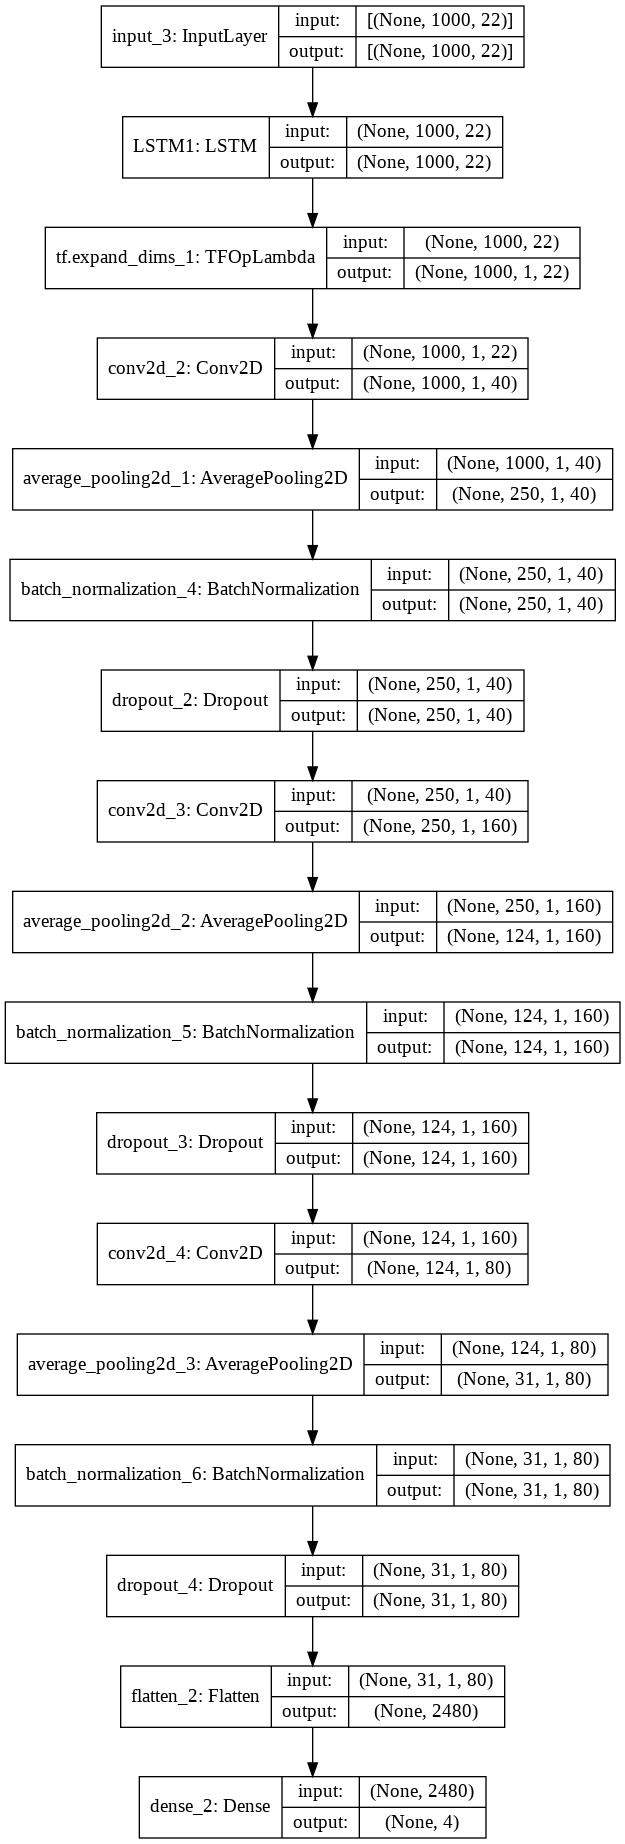

In [ ]:
plot_model(model,"LSTM-CNN_adaptive reg -1.png", show_shapes=True)

**Attempt** LSTM 6 units and contant regularization of 0.1 for all layers

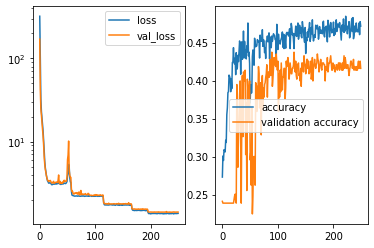

Val Accuracy 0.4160756468772888
Test Accuracy 0.43340858817100525


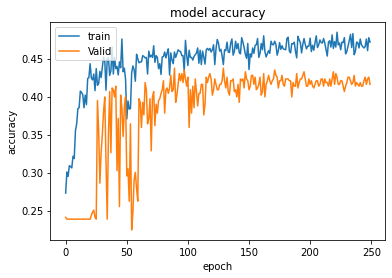

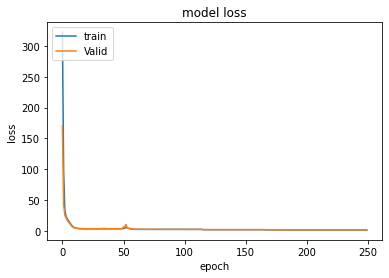

In [ ]:
reg = regularizers.l1_l2(l1=0.1, l2=0.1)

inputs = tf.keras.Input(shape=(1000,22))

out1 = layers.LSTM(6, return_sequences=True,kernel_regularizer= reg,recurrent_regularizer= reg, name="LSTM1")(inputs)#out1a: None,1000,6

out2 = tf.expand_dims(out1, 2)#out3: None, 1000,1,6

out3 = layers.Conv2D(40, (8,1), padding = 'same',kernel_regularizer= reg, activation = 'elu')(out2) #out3: None, 1000, 1, 40
out4 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out3) #out4: None, 249+1, 1, 40
out5 = layers.BatchNormalization()(out4) #out5: None, 250,1,40
out6 = layers.Dropout(0.5)(out5) #out6: None, 250, 1, 40

out7 = layers.Conv2D(filters = 160, kernel_size = (8,1),kernel_regularizer= reg, padding = 'same', activation = 'elu')(out6) #out6: None, 250, 1, 80
out8 = layers.AveragePooling2D(pool_size = (4,1),strides = (2,1))(out7) #out8: None,124, 1, 80
out9 = layers.BatchNormalization()(out8)
out10 = layers.Dropout(0.5)(out9)

out11 = layers.Conv2D(filters = 80, kernel_size = (8,1),kernel_regularizer= reg, padding = 'same', activation = 'elu')(out10) #out10: None, 124, 1, 80
out12 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out11) #out11: None,31, 1, 80
out13 = layers.BatchNormalization()(out12)
out14 = layers.Dropout(0.5)(out13)

out15 = layers.Flatten()(out14)
out16 = layers.Dense(4, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)
#model.summary()

optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(X_lstm_tv, y_tv_onehot, test_size=0.2)
c_callbacks = get_cb("lstm_Der_6_fullreg_e250")
history = model.fit(X_train,y_train, batch_size = 64, epochs = 250, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(X_lstm_test,y_test_onehot, verbose = 0)
print('Test Accuracy', score[1])

Loss_big_img(history)

In [ ]:
#CHANGED NO> LSTM units to 12
inputs = tf.keras.Input(shape=(1000,22))

out1 = layers.LSTM(12, return_sequences=True, name="LSTM1")(inputs)#out1a: None,1000,12

out2 = tf.expand_dims(out1, 2)#out3: None, 1000,1,12

out3 = layers.Conv2D(40, (8,1), padding = 'same', activation = 'elu')(out2) #out3: None, 1000, 1, 40
out4 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out3) #out4: None, 249+1, 1, 40
out5 = layers.BatchNormalization()(out4) #out5: None, 250,1,40
out6 = layers.Dropout(0.5)(out5) #out6: None, 250, 1, 40

out7 = layers.Conv2D(filters = 160, kernel_size = (8,1), padding = 'same', activation = 'elu')(out6) #out6: None, 250, 1, 80
out8 = layers.AveragePooling2D(pool_size = (4,1),strides = (2,1))(out7) #out8: None,124, 1, 80
out9 = layers.BatchNormalization()(out8)
out10 = layers.Dropout(0.5)(out9)

out11 = layers.Conv2D(filters = 80, kernel_size = (8,1), padding = 'same', activation = 'elu')(out10) #out10: None, 124, 1, 80
out12 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out11) #out11: None,31, 1, 80
out13 = layers.BatchNormalization()(out12)
out14 = layers.Dropout(0.5)(out13)

out15 = layers.Flatten()(out14)
out16 = layers.Dense(4, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1000, 22)]        0         
_________________________________________________________________
LSTM1 (LSTM)                 (None, 1000, 12)          1680      
_________________________________________________________________
tf.expand_dims_3 (TFOpLambda (None, 1000, 1, 12)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1000, 1, 40)       3880      
_________________________________________________________________
average_pooling2d_5 (Average (None, 250, 1, 40)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 250, 1, 40)        160       
_________________________________________________________________
dropout_3 (Dropout)          (None, 250, 1, 40)        0   

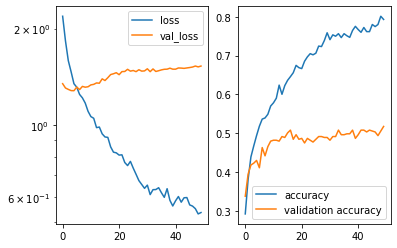

Val Accuracy 0.5177304744720459
Test Accuracy 0.5079006552696228


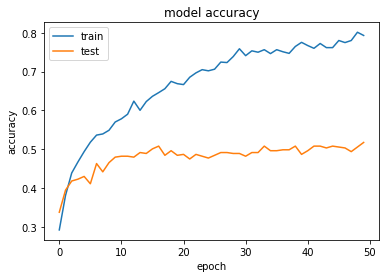

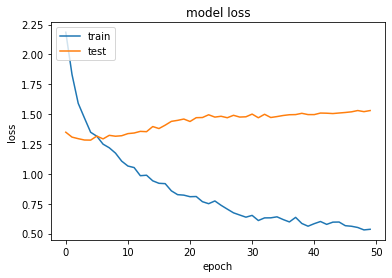

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 5e-4)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(X_lstm_tv, y_tv_onehot, test_size=0.2)
c_callbacks = get_cb("lstm_derek2")
history = model.fit(X_train,y_train, batch_size = 64, epochs = 50, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(X_lstm_test,y_test_onehot, verbose = 0)
print('Test Accuracy', score[1])

Loss_big_img(history)

**Initial attempts** Adding dropout to LSTM

In [ ]:
inputs = tf.keras.Input(shape=(1000,22))

out1 = layers.LSTM(12, dropout = 0.5, return_sequences=True, name="LSTM1")(inputs)#out1a: None,1000,12

out2 = tf.expand_dims(out1, 2)#out3: None, 1000,1,12

out3 = layers.Conv2D(40, (8,1), padding = 'same', activation = 'elu')(out2) #out3: None, 1000, 1, 40
out4 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out3) #out4: None, 249+1, 1, 40
out5 = layers.BatchNormalization()(out4) #out5: None, 250,1,40
out6 = layers.Dropout(0.5)(out5) #out6: None, 250, 1, 40

out7 = layers.Conv2D(filters = 160, kernel_size = (8,1), padding = 'same', activation = 'elu')(out6) #out6: None, 250, 1, 80
out8 = layers.AveragePooling2D(pool_size = (4,1),strides = (2,1))(out7) #out8: None,124, 1, 80
out9 = layers.BatchNormalization()(out8)
out10 = layers.Dropout(0.5)(out9)

out11 = layers.Conv2D(filters = 80, kernel_size = (8,1), padding = 'same', activation = 'elu')(out10) #out10: None, 124, 1, 80
out12 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out11) #out11: None,31, 1, 80
out13 = layers.BatchNormalization()(out12)
out14 = layers.Dropout(0.5)(out13)

out15 = layers.Flatten()(out14)
out16 = layers.Dense(4, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)
#model.summary()

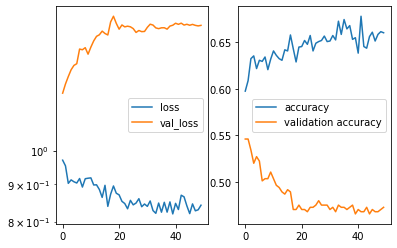

Val Accuracy 0.4728132486343384
Test Accuracy 0.42889389395713806


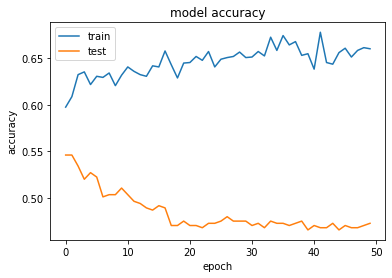

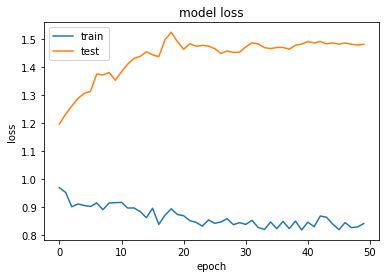

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 1e-4)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(X_lstm_tv, y_tv_onehot, test_size=0.2)
c_callbacks = get_cb("lstm_Der_drop")
history = model.fit(X_train,y_train, batch_size = 64, epochs = 50, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(X_lstm_test,y_test_onehot, verbose = 0)
print('Test Accuracy', score[1])

Loss_big_img(history)

In [ ]:
inputs = tf.keras.Input(shape=(1000,22))

out1 = layers.LSTM(22, return_sequences=True, name="LSTM1")(inputs)#out1a: None,1000,12

out2 = tf.expand_dims(out1, 2)#out3: None, 1000,1,12

out3 = layers.Conv2D(40, (8,1), padding = 'same', activation = 'elu')(out2) #out3: None, 1000, 1, 40
out4 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out3) #out4: None, 249+1, 1, 40
out5 = layers.BatchNormalization()(out4) #out5: None, 250,1,40
out6 = layers.Dropout(0.5)(out5) #out6: None, 250, 1, 40

out7 = layers.Conv2D(filters = 160, kernel_size = (8,1), padding = 'same', activation = 'elu')(out6) #out6: None, 250, 1, 80
out8 = layers.AveragePooling2D(pool_size = (4,1),strides = (2,1))(out7) #out8: None,124, 1, 80
out9 = layers.BatchNormalization()(out8)
out10 = layers.Dropout(0.5)(out9)

out11 = layers.Conv2D(filters = 80, kernel_size = (8,1), padding = 'same', activation = 'elu')(out10) #out10: None, 124, 1, 80
out12 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out11) #out11: None,31, 1, 80
out13 = layers.BatchNormalization()(out12)
out14 = layers.Dropout(0.5)(out13)

out15 = layers.Flatten()(out14)
out16 = layers.Dense(4, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)
#model.summary()

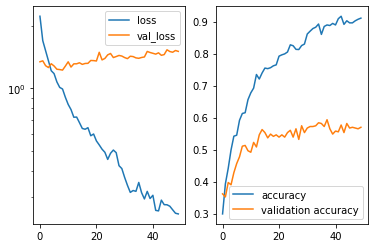

Val Accuracy 0.5697399377822876
Test Accuracy 0.5530474185943604


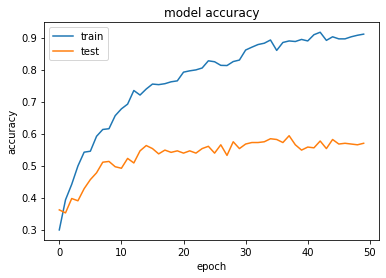

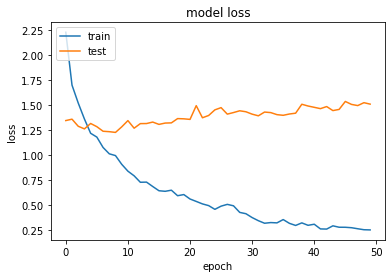

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(X_lstm_tv, y_tv_onehot, test_size=0.2)
c_callbacks = get_cb("lstm_Der_22")
history = model.fit(X_train,y_train, batch_size = 64, epochs = 50, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(X_lstm_test,y_test_onehot, verbose = 0)
print('Test Accuracy', score[1])

Loss_big_img(history)

**Attempt** LSTM with 8 units

In [ ]:
inputs = tf.keras.Input(shape=(1000,22))

out1 = layers.LSTM(8, return_sequences=True, name="LSTM1")(inputs)#out1a: None,1000,8

out2 = tf.expand_dims(out1, 2)#out3: None, 1000,1,12

out3 = layers.Conv2D(40, (8,1), padding = 'same', activation = 'elu')(out2) #out3: None, 1000, 1, 40
out4 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out3) #out4: None, 249+1, 1, 40
out5 = layers.BatchNormalization()(out4) #out5: None, 250,1,40
out6 = layers.Dropout(0.5)(out5) #out6: None, 250, 1, 40

out7 = layers.Conv2D(filters = 160, kernel_size = (8,1), padding = 'same', activation = 'elu')(out6) #out6: None, 250, 1, 80
out8 = layers.AveragePooling2D(pool_size = (4,1),strides = (2,1))(out7) #out8: None,124, 1, 80
out9 = layers.BatchNormalization()(out8)
out10 = layers.Dropout(0.5)(out9)

out11 = layers.Conv2D(filters = 80, kernel_size = (8,1), padding = 'same', activation = 'elu')(out10) #out10: None, 124, 1, 80
out12 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out11) #out11: None,31, 1, 80
out13 = layers.BatchNormalization()(out12)
out14 = layers.Dropout(0.5)(out13)

out15 = layers.Flatten()(out14)
out16 = layers.Dense(4, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)
#model.summary()

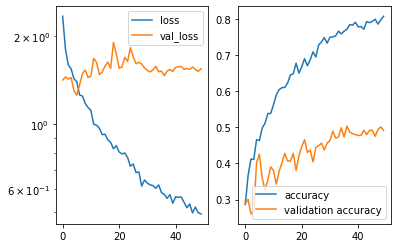

Val Accuracy 0.49172577261924744
Test Accuracy 0.505643367767334


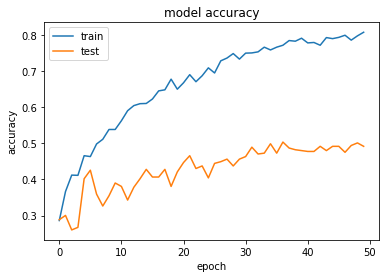

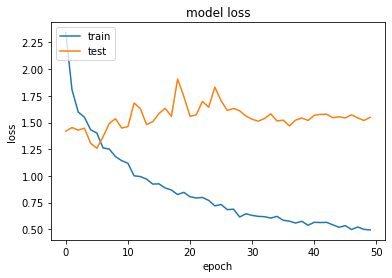

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(X_lstm_tv, y_tv_onehot, test_size=0.2)
c_callbacks = get_cb("lstm_Der_8u")
history = model.fit(X_train,y_train, batch_size = 64, epochs = 50, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(X_lstm_test,y_test_onehot, verbose = 0)
print('Test Accuracy', score[1])

Loss_big_img(history)

**Initial Attempt** Add regularization

In [ ]:
reg = regularizers.l2(0.1)

In [ ]:
inputs = tf.keras.Input(shape=(1000,22))

out1 = layers.LSTM(8, return_sequences=True,kernel_regularizer= reg,recurrent_regularizer= reg, name="LSTM1")(inputs)#out1a: None,1000,8

out2 = tf.expand_dims(out1, 2)#out3: None, 1000,1,12

out3 = layers.Conv2D(40, (8,1), padding = 'same',kernel_regularizer= reg, activation = 'elu')(out2) #out3: None, 1000, 1, 40
out4 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out3) #out4: None, 249+1, 1, 40
out5 = layers.BatchNormalization()(out4) #out5: None, 250,1,40
out6 = layers.Dropout(0.5)(out5) #out6: None, 250, 1, 40

out7 = layers.Conv2D(filters = 160, kernel_size = (8,1),kernel_regularizer= reg, padding = 'same', activation = 'elu')(out6) #out6: None, 250, 1, 80
out8 = layers.AveragePooling2D(pool_size = (4,1),strides = (2,1))(out7) #out8: None,124, 1, 80
out9 = layers.BatchNormalization()(out8)
out10 = layers.Dropout(0.5)(out9)

out11 = layers.Conv2D(filters = 320, kernel_size = (8,1),kernel_regularizer= reg, padding = 'same', activation = 'elu')(out10) #out10: None, 124, 1, 320
out12 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out11) #out11: None,31, 1, 320
out13 = layers.BatchNormalization()(out12)
out14 = layers.Dropout(0.5)(out13)

out15 = layers.Flatten()(out14)
out16 = layers.Dense(4, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)

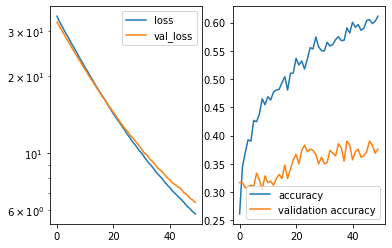

Val Accuracy 0.3758865296840668
Test Accuracy 0.3769751787185669


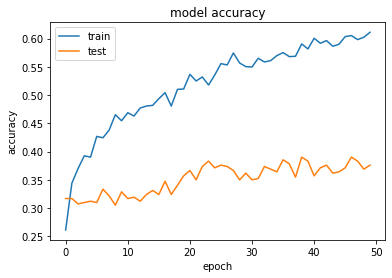

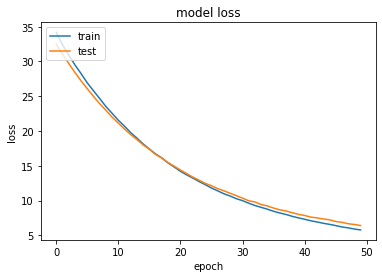

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 1e-4)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(X_lstm_tv, y_tv_onehot, test_size=0.2)
c_callbacks = get_cb("lstm_Der_8ureg")
history = model.fit(X_train,y_train, batch_size = 64, epochs = 50, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(X_lstm_test,y_test_onehot, verbose = 0)
print('Test Accuracy', score[1])

Loss_big_img(history)

Above shows a very smooth loss surface. Let me try **Chopping the final conv2d** increasing no. of epochs, inc lr and add l1 reg as well

In [ ]:
#l1_l2(l1=1e-5, l2=1e-4)
reg = regularizers.l1_l2(l1=0.1, l2=0.1)

In [ ]:
inputs = tf.keras.Input(shape=(1000,22))

out1 = layers.LSTM(8, return_sequences=True,kernel_regularizer= reg,recurrent_regularizer= reg, name="LSTM1")(inputs)#out1a: None,1000,8

out2 = tf.expand_dims(out1, 2)#out3: None, 1000,1,12

out3 = layers.Conv2D(40, (8,1), padding = 'same',kernel_regularizer= reg, activation = 'elu')(out2) #out3: None, 1000, 1, 40
out4 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out3) #out4: None, 249+1, 1, 40
out5 = layers.BatchNormalization()(out4) #out5: None, 250,1,40
out6 = layers.Dropout(0.5)(out5) #out6: None, 250, 1, 40

out7 = layers.Conv2D(filters = 160, kernel_size = (8,1),kernel_regularizer= reg, padding = 'same', activation = 'elu')(out6) #out6: None, 250, 1, 80
out8 = layers.AveragePooling2D(pool_size = (4,1),strides = (2,1))(out7) #out8: None,124, 1, 80
out9 = layers.BatchNormalization()(out8)
out10 = layers.Dropout(0.5)(out9)

#out11 = layers.Conv2D(filters = 320, kernel_size = (8,1),kernel_regularizer= reg, padding = 'same', activation = 'elu')(out10) #out10: None, 124, 1, 320
#out12 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out11) #out11: None,31, 1, 320
#out13 = layers.BatchNormalization()(out12)
#out14 = layers.Dropout(0.5)(out13)

out15 = layers.Flatten()(out10)
out16 = layers.Dense(4, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)

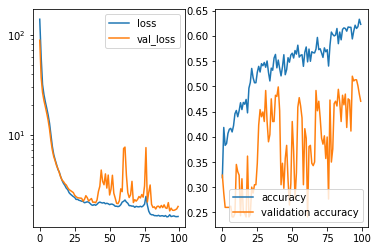

Val Accuracy 0.47044917941093445
Test Accuracy 0.44018059968948364


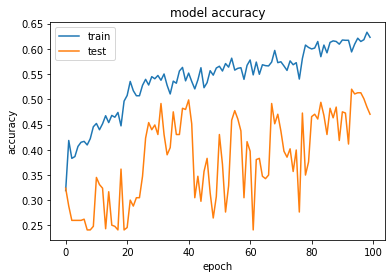

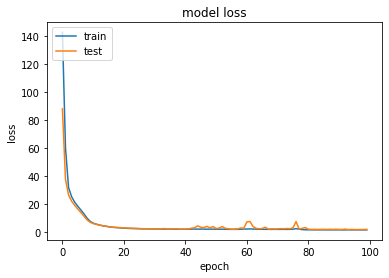

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(X_lstm_tv, y_tv_onehot, test_size=0.2)
c_callbacks = get_cb("lstm_Der_8_l12")
history = model.fit(X_train,y_train, batch_size = 64, epochs = 100, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(X_lstm_test,y_test_onehot, verbose = 0)
print('Test Accuracy', score[1])

Loss_big_img(history)

**Initial Attempts** Only two Conv layers after LSTM

In [ ]:
reg = regularizers.l1_l2(l1=0.1, l2=0.1)

inputs = tf.keras.Input(shape=(1000,22))

out1 = layers.LSTM(8, return_sequences=True,kernel_regularizer= reg,recurrent_regularizer= reg, name="LSTM1")(inputs)#out1a: None,1000,8

out2 = tf.expand_dims(out1, 2)#out3: None, 1000,1,12

out3 = layers.Conv2D(40, (8,1), padding = 'same',kernel_regularizer= reg, activation = 'elu')(out2) #out3: None, 1000, 1, 40
out4 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out3) #out4: None, 249+1, 1, 40
out5 = layers.BatchNormalization()(out4) #out5: None, 250,1,40
out6 = layers.Dropout(0.5)(out5) #out6: None, 250, 1, 40

out7 = layers.Conv2D(filters = 160, kernel_size = (8,1),kernel_regularizer= reg, padding = 'same', activation = 'elu')(out6) #out6: None, 250, 1, 80
out8 = layers.AveragePooling2D(pool_size = (4,1),strides = (2,1))(out7) #out8: None,124, 1, 80
out9 = layers.BatchNormalization()(out8)
out10 = layers.Dropout(0.5)(out9)

out15 = layers.Flatten()(out10)
out16 = layers.Dense(4, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)

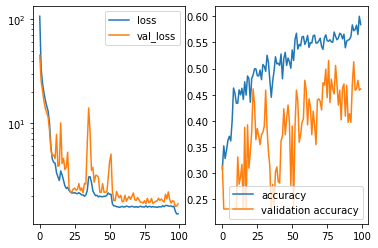

Val Accuracy 0.4609929025173187
Test Accuracy 0.43792325258255005


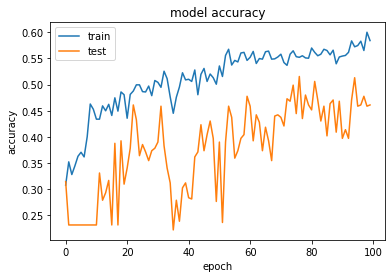

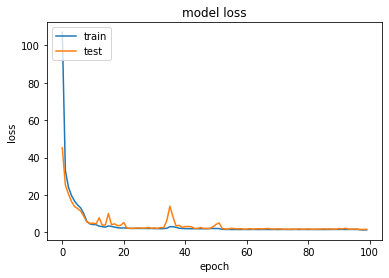

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(X_lstm_tv, y_tv_onehot, test_size=0.2)
c_callbacks = get_cb("lstm_Der_8_l12_e100")
history = model.fit(X_train,y_train, batch_size = 32, epochs = 100, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(X_lstm_test,y_test_onehot, verbose = 0)
print('Test Accuracy', score[1])

Loss_big_img(history)

In [ ]:
reg = regularizers.l1_l2(l1=0.1, l2=0.1)

inputs = tf.keras.Input(shape=(1000,22))

out1 = layers.LSTM(8, return_sequences=True,kernel_regularizer= reg,recurrent_regularizer= reg, name="LSTM1")(inputs)#out1a: None,1000,8

out2 = tf.expand_dims(out1, 2)#out3: None, 1000,1,12

out3 = layers.Conv2D(40, (8,1), padding = 'same',kernel_regularizer= reg, activation = 'elu')(out2) #out3: None, 1000, 1, 40
out4 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out3) #out4: None, 249+1, 1, 40
out5 = layers.BatchNormalization()(out4) #out5: None, 250,1,40
out6 = layers.Dropout(0.5)(out5) #out6: None, 250, 1, 40

out7 = layers.Conv2D(filters = 160, kernel_size = (8,1),kernel_regularizer= reg, padding = 'same', activation = 'elu')(out6) #out6: None, 250, 1, 80
out8 = layers.AveragePooling2D(pool_size = (4,1),strides = (2,1))(out7) #out8: None,124, 1, 80
out9 = layers.BatchNormalization()(out8)
out10 = layers.Dropout(0.5)(out9)

out11 = layers.Conv2D(filters = 320, kernel_size = (8,1),kernel_regularizer= reg, padding = 'same', activation = 'elu')(out10) #out10: None, 124, 1, 320
out12 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out11) #out11: None,31, 1, 320
out13 = layers.BatchNormalization()(out12)
out14 = layers.Dropout(0.5)(out13)

out15 = layers.Flatten()(out10)
out16 = layers.Dense(4, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)

Try above with some higher learning rate

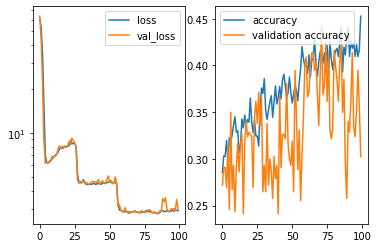

Val Accuracy 0.3026004731655121
Test Accuracy 0.2821670472621918


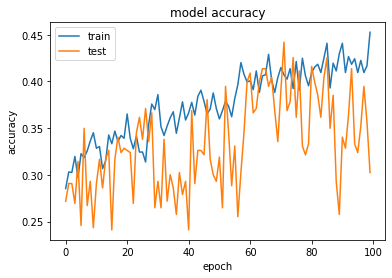

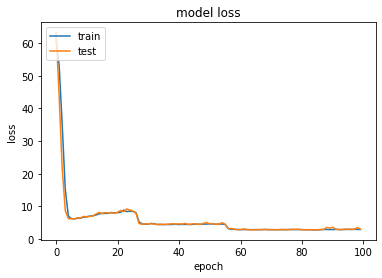

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 1e-2)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(X_lstm_tv, y_tv_onehot, test_size=0.2)
c_callbacks = get_cb("lstm_Der_8_reg_highlr")
history = model.fit(X_train,y_train, batch_size = 32, epochs = 100, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(X_lstm_test,y_test_onehot, verbose = 0)
print('Test Accuracy', score[1])

Loss_big_img(history)

lr 1e-1 250 epochs

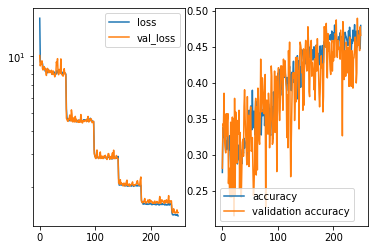

Val Accuracy 0.4657210409641266
Test Accuracy 0.45146727561950684


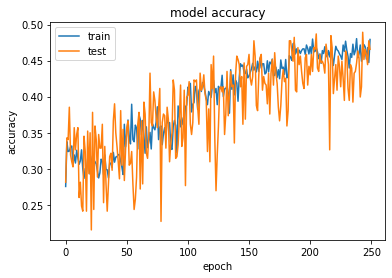

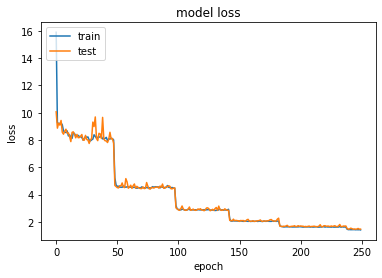

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 1e-2)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(X_lstm_tv, y_tv_onehot, test_size=0.2)
c_callbacks = get_cb("lstm_Der_8_reg_higherlr")
history = model.fit(X_train,y_train, batch_size = 32, epochs = 250, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(X_lstm_test,y_test_onehot, verbose = 0)
print('Test Accuracy', score[1])

Loss_big_img(history)

1000 epochs

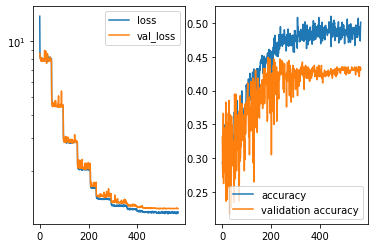

Epoch 00568: early stopping
Val Accuracy 0.43262410163879395
Test Accuracy 0.4063205420970917


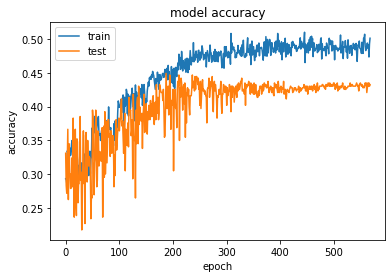

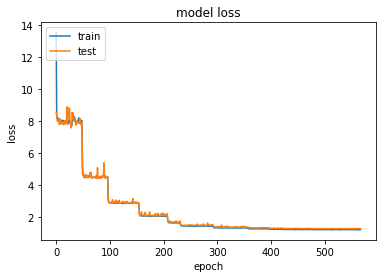

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 1e-2)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(X_lstm_tv, y_tv_onehot, test_size=0.2)
c_callbacks = get_cb("lstm_Der_8_reg_higherlr_1000e")
history = model.fit(X_train,y_train, batch_size = 32, epochs = 1000, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(X_lstm_test,y_test_onehot, verbose = 0)
print('Test Accuracy', score[1])

Loss_big_img(history)

With Lower lr = 1e-4

In [ ]:
"""
optimizer = tf.keras.optimizers.Adam(lr = 1e-4)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(X_lstm_tv, y_tv_onehot, test_size=0.2)
c_callbacks = get_cb("lstm_Der_8_reg_lowlr")
history = model.fit(X_train,y_train, batch_size = 32, epochs = 100, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(X_lstm_test,y_test_onehot, verbose = 0)
print('Test Accuracy', score[1])

Loss_big_img(history)
"""

'\noptimizer = tf.keras.optimizers.Adam(lr = 1e-4)\nmodel.compile(loss = \'categorical_crossentropy\',optimizer = optimizer, metrics = [\'accuracy\'])\n\nX_train, X_val, y_train, y_val = train_test_split(X_lstm_tv, y_tv_onehot, test_size=0.2)\nc_callbacks = get_cb("lstm_Der_8_reg_lowlr")\nhistory = model.fit(X_train,y_train, batch_size = 32, epochs = 100, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)\n\nscore = model.evaluate(X_val ,y_val, verbose = 0)\nprint(\'Val Accuracy\', score[1])\n\nscore = model.evaluate(X_lstm_test,y_test_onehot, verbose = 0)\nprint(\'Test Accuracy\', score[1])\n\nLoss_big_img(history)\n'

Try above with de-noised X

In [ ]:
reg = regularizers.l1_l2(l1=0.1, l2=0.1)

inputs = tf.keras.Input(shape=(1000,22))

out1 = layers.LSTM(8, return_sequences=True,kernel_regularizer= reg,recurrent_regularizer= reg, name="LSTM1")(inputs)#out1a: None,1000,8

out2 = tf.expand_dims(out1, 2)#out3: None, 1000,1,12

out3 = layers.Conv2D(40, (8,1), padding = 'same',kernel_regularizer= reg, activation = 'elu')(out2) #out3: None, 1000, 1, 40
out4 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out3) #out4: None, 249+1, 1, 40
out5 = layers.BatchNormalization()(out4) #out5: None, 250,1,40
out6 = layers.Dropout(0.5)(out5) #out6: None, 250, 1, 40

out7 = layers.Conv2D(filters = 160, kernel_size = (8,1),kernel_regularizer= reg, padding = 'same', activation = 'elu')(out6) #out6: None, 250, 1, 80
out8 = layers.AveragePooling2D(pool_size = (4,1),strides = (2,1))(out7) #out8: None,124, 1, 80
out9 = layers.BatchNormalization()(out8)
out10 = layers.Dropout(0.5)(out9)

out15 = layers.Flatten()(out10)
out16 = layers.Dense(4, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)

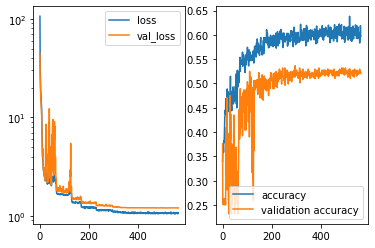

Epoch 00563: early stopping
Val Accuracy 0.5224586129188538
Test Accuracy 0.4988713264465332


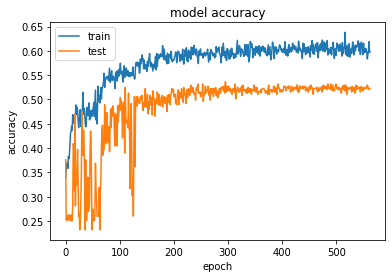

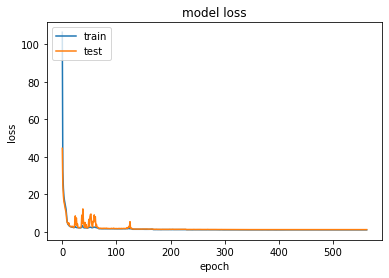

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(Xred_lstm_tv, y_tv_onehot, test_size=0.2)
c_callbacks = get_cb("lstm_Der_red_8_higherlr_e1000")
history = model.fit(X_train,y_train, batch_size = 32, epochs = 1000, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(Xred_lstm_test,y_test_onehot, verbose = 0)
print('Test Accuracy', score[1])

Loss_big_img(history)

**Attempt** Comparing model with relu and 3 Conv Layers

In [ ]:
reg = regularizers.l1_l2(l1=0.1, l2=0.1)

inputs = tf.keras.Input(shape=(1000,22))

out1 = layers.LSTM(8, return_sequences=True,kernel_regularizer= reg,recurrent_regularizer= reg, name="LSTM1")(inputs)#out1a: None,1000,8

out2 = tf.expand_dims(out1, 2)#out3: None, 1000,1,12

out3 = layers.Conv2D(40, (8,1), padding = 'same',kernel_regularizer= reg, activation = 'relu')(out2) #out3: None, 1000, 1, 40
out4 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out3) #out4: None, 249+1, 1, 40
out5 = layers.BatchNormalization()(out4) #out5: None, 250,1,40
out6 = layers.Dropout(0.5)(out5) #out6: None, 250, 1, 40

out7 = layers.Conv2D(filters = 160, kernel_size = (8,1),kernel_regularizer= reg, padding = 'same', activation = 'relu')(out6) #out6: None, 250, 1, 80
out8 = layers.AveragePooling2D(pool_size = (4,1),strides = (2,1))(out7) #out8: None,124, 1, 80
out9 = layers.BatchNormalization()(out8)
out10 = layers.Dropout(0.5)(out9)

out11 = layers.Conv2D(filters = 320, kernel_size = (8,1),kernel_regularizer= reg, padding = 'same', activation = 'relu')(out10) #out10: None, 124, 1, 320
out12 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out11) #out11: None,31, 1, 320
out13 = layers.BatchNormalization()(out12)
out14 = layers.Dropout(0.5)(out13)

out15 = layers.Flatten()(out14)
out16 = layers.Dense(4, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)

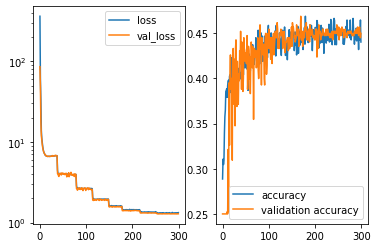

Val Accuracy 0.44917258620262146
Test Accuracy 0.3792324960231781


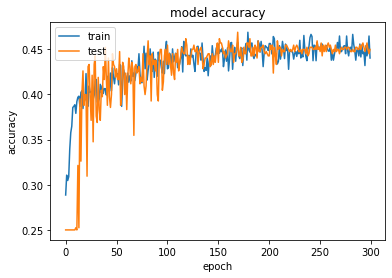

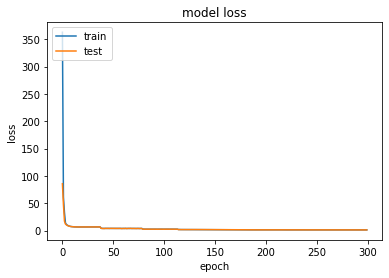

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(Xred_lstm_tv, y_tv_onehot, test_size=0.2)
c_callbacks = get_cb("lstm_Der_red_8_relu_e300")
history = model.fit(X_train,y_train, batch_size = 32, epochs = 300, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(Xred_lstm_test,y_test_onehot, verbose = 0)
print('Test Accuracy', score[1])

Loss_big_img(history)

**Initial Attempt** Considering elu and we get:

In [ ]:
reg = regularizers.l1_l2(l1=0.15, l2=0.15)

inputs = tf.keras.Input(shape=(1000,22))

out1 = layers.LSTM(8, return_sequences=True,kernel_regularizer= reg,recurrent_regularizer= reg, name="LSTM1")(inputs)#out1a: None,1000,8

out2 = tf.expand_dims(out1, 2)#out3: None, 1000,1,12

out3 = layers.Conv2D(40, (8,1), padding = 'same',kernel_regularizer= reg, activation = 'elu')(out2) #out3: None, 1000, 1, 40
out4 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out3) #out4: None, 249+1, 1, 40
out5 = layers.BatchNormalization()(out4) #out5: None, 250,1,40
out6 = layers.Dropout(0.5)(out5) #out6: None, 250, 1, 40

out7 = layers.Conv2D(filters = 160, kernel_size = (8,1),kernel_regularizer= reg, padding = 'same', activation = 'elu')(out6) #out6: None, 250, 1, 80
out8 = layers.AveragePooling2D(pool_size = (4,1),strides = (2,1))(out7) #out8: None,124, 1, 80
out9 = layers.BatchNormalization()(out8)
out10 = layers.Dropout(0.5)(out9)

out11 = layers.Conv2D(filters = 320, kernel_size = (8,1),kernel_regularizer= reg, padding = 'same', activation = 'elu')(out10) #out10: None, 124, 1, 320
out12 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out11) #out11: None,31, 1, 320
out13 = layers.BatchNormalization()(out12)
out14 = layers.Dropout(0.5)(out13)

out15 = layers.Flatten()(out14)
out16 = layers.Dense(4, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)

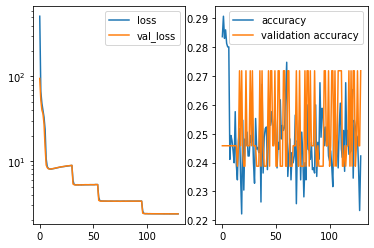

Epoch 131/300
13/53 [======>.......................] - ETA: 1s - loss: 2.3775 - accuracy: 0.2678

KeyboardInterrupt: ignored

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(Xred_lstm_tv, y_tv_onehot, test_size=0.2)
c_callbacks = get_cb("lstm_Der_red_8elu_full_e300")
history = model.fit(X_train,y_train, batch_size = 32, epochs = 300, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(Xred_lstm_test,y_test_onehot, verbose = 0)
print('Test Accuracy', score[1])

Loss_big_img(history)

**Conclusion:** Elu vs relu: elu relu gives 45 % test acc but elu gives 50 %)

15 units and 250 epochs (Decide FUll or not; relu or elu)

### LSTM-CNN-1_constant reg

In [ ]:
reg = regularizers.l1_l2(l1=0.05, l2=0.05)

inputs = tf.keras.Input(shape=(1000,22))

out1 = layers.LSTM(15, return_sequences=True,kernel_regularizer= reg,recurrent_regularizer= reg, name="LSTM1")(inputs)#out1a: None,1000,15

out2 = tf.expand_dims(out1, 2)#out3: None, 1000,1,15

out3 = layers.Conv2D(40, (8,1), padding = 'same',kernel_regularizer= reg, activation = 'elu')(out2) #out3: None, 1000, 1, 40
out4 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out3) #out4: None, 249+1, 1, 40
out5 = layers.BatchNormalization()(out4) #out5: None, 250,1,40
out6 = layers.Dropout(0.5)(out5) #out6: None, 250, 1, 40

out7 = layers.Conv2D(filters = 160, kernel_size = (8,1),kernel_regularizer= reg, padding = 'same', activation = 'elu')(out6) #out6: None, 250, 1, 80
out8 = layers.AveragePooling2D(pool_size = (4,1),strides = (2,1))(out7) #out8: None,124, 1, 80
out9 = layers.BatchNormalization()(out8)
out10 = layers.Dropout(0.5)(out9)

out15 = layers.Flatten()(out10)
out16 = layers.Dense(4, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)

In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1000, 22)]        0         
_________________________________________________________________
LSTM1 (LSTM)                 (None, 1000, 15)          2280      
_________________________________________________________________
tf.expand_dims_4 (TFOpLambda (None, 1000, 1, 15)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1000, 1, 40)       4840      
_________________________________________________________________
average_pooling2d_10 (Averag (None, 250, 1, 40)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 250, 1, 40)        160       
_________________________________________________________________
dropout_11 (Dropout)         (None, 250, 1, 40)        0   

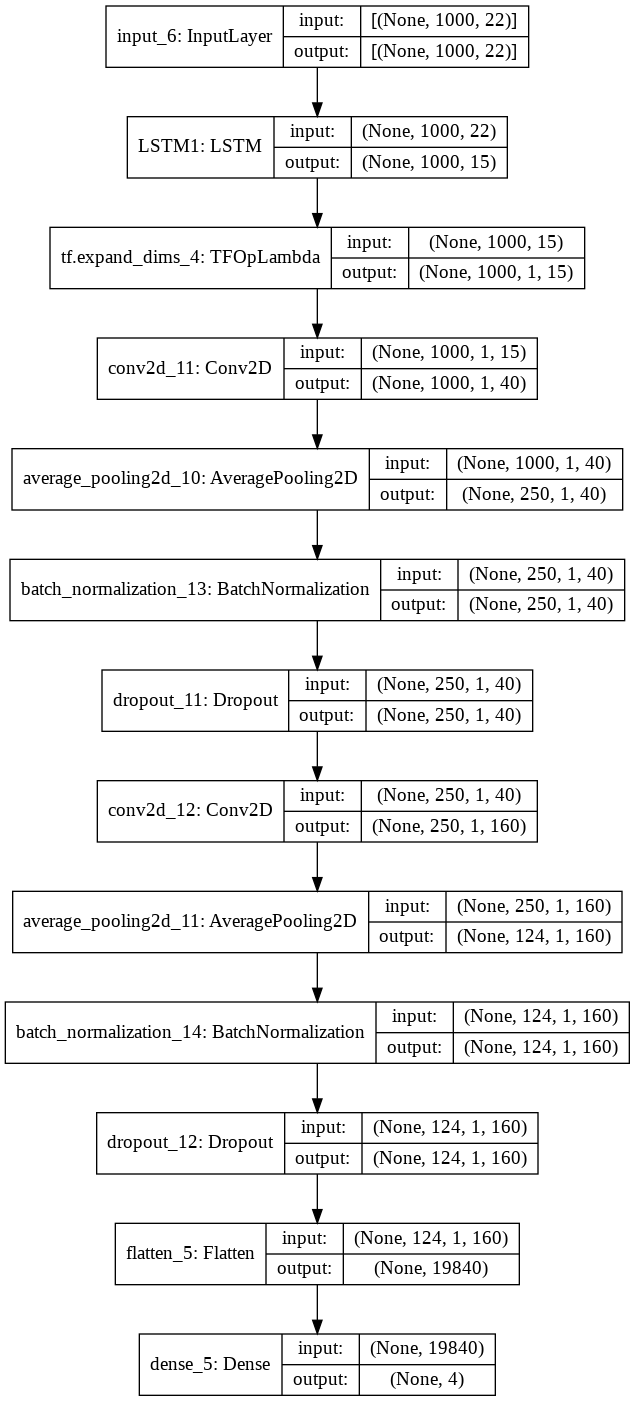

In [ ]:
plot_model(model,"LSTM-CNN-1_constant reg.png",show_shapes=True)

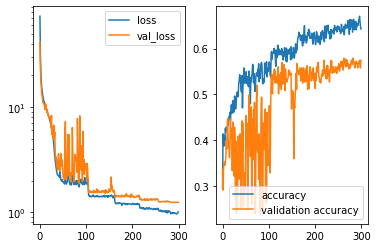

Val Accuracy 0.5744680762290955
Test Accuracy 0.5530474185943604


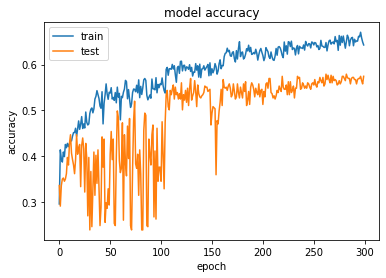

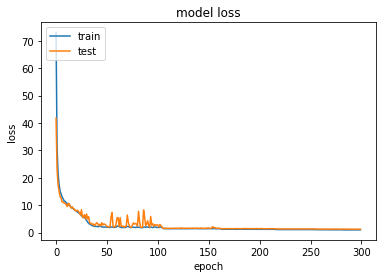

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(Xred_lstm_tv, y_tv_onehot, test_size=0.2)
c_callbacks = get_cb("lstm_Der_red_15elu_e300")
history = model.fit(X_train,y_train, batch_size = 32, epochs = 300, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(Xred_lstm_test,y_test_onehot, verbose = 0)
print('Test Accuracy', score[1])

Loss_big_img(history)

Applied regularization, increased dropout

In [ ]:
reg = regularizers.l1_l2(l1=0.05, l2=0.05)

inputs = tf.keras.Input(shape=(1000,22))

out1 = layers.LSTM(15, dropout = 0.6,return_sequences=True,kernel_regularizer= reg,recurrent_regularizer= reg, name="LSTM1")(inputs)#out1a: None,1000,15

out2 = tf.expand_dims(out1, 2)#out3: None, 1000,1,15

out3 = layers.Conv2D(40, (8,1), padding = 'same',kernel_regularizer= reg, activation = 'elu')(out2) #out3: None, 1000, 1, 40
out4 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out3) #out4: None, 249+1, 1, 40
out5 = layers.BatchNormalization()(out4) #out5: None, 250,1,40
out6 = layers.Dropout(0.6)(out5) #out6: None, 250, 1, 40

out7 = layers.Conv2D(filters = 160, kernel_size = (8,1),kernel_regularizer= reg, padding = 'same', activation = 'elu')(out6) #out6: None, 250, 1, 80
out8 = layers.AveragePooling2D(pool_size = (4,1),strides = (2,1))(out7) #out8: None,124, 1, 80
out9 = layers.BatchNormalization()(out8)
out10 = layers.Dropout(0.6)(out9)
6
#out11 = layers.Conv2D(filters = 320, kernel_size = (8,1),kernel_regularizer= reg, padding = 'same', activation = 'elu')(out10) #out10: None, 124, 1, 320
#out12 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out11) #out11: None,31, 1, 320
#out13 = layers.BatchNormalization()(out12)
#out14 = layers.Dropout(0.5)(out13)

out15 = layers.Flatten()(out10)
out16 = layers.Dense(4, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)

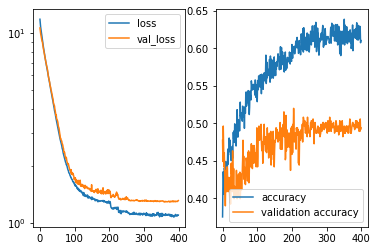

Val Accuracy 0.49408984184265137
Test Accuracy 0.4943566620349884


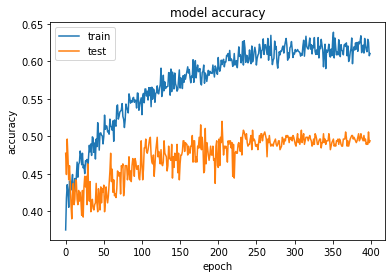

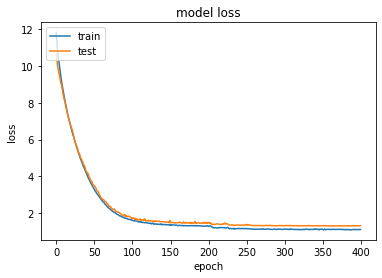

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 1e-4)
model.compile(loss = 'sparse_categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(Xred_lstm_tv, y_train_valid, test_size=0.2)
c_callbacks = get_cb("lstm_Der_red_drop_15elu_e400")
history = model.fit(X_train,y_train, batch_size = 64, epochs = 400, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(Xred_lstm_test,y_test, verbose = 0)
print('Test Accuracy', score[1])

Loss_big_img(history)

**Observation** Increased units and lowered reg helps.
Let me increase units to 22, use lower reg and higher dropout

### LSTM-CNN-2_constant reg

In [ ]:
reg = regularizers.l1_l2(l1=0.01, l2=0.01)

inputs = tf.keras.Input(shape=(1000,22))

out1a = layers.LSTM(22, dropout = 0.5, return_sequences=True,kernel_regularizer= reg,recurrent_regularizer= reg, name="LSTM1a")(inputs)#out1a: None,1000,15
out2a = tf.expand_dims(out1a, 2)#out3: None, 1000,1,15
out3a = layers.Conv2D(40, (8,1), padding = 'same',kernel_regularizer= reg, activation = 'elu')(out2a) #out3: None, 1000, 1, 40
out4a = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out3a) #out4: None, 249+1, 1, 40
out5a = layers.BatchNormalization()(out4a) #out5: None, 250,1,40
out6a = layers.Dropout(0.6)(out5a) #out6: None, 250, 1, 40

out1b = layers.LSTM(22, dropout = 0.5, return_sequences=True,kernel_regularizer= reg,recurrent_regularizer= reg, name="LSTM1b")(inputs)#out1b: None,1000,15
out2b = tf.expand_dims(out1b, 2)#out3: None, 1000,1,15
out3b = layers.Conv2D(40, (8,1), padding = 'same',kernel_regularizer= reg, activation = 'elu')(out2b) #out3: None, 1000, 1, 40
out4b = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out3b) #out4: None, 249+1, 1, 40
out5b = layers.BatchNormalization()(out4b) #out5: None, 250,1,40
out6b = layers.Dropout(0.6)(out5b) #out6: None, 250, 1, 40

out6 = layers.Concatenate(axis = 2)([out6a, out6b]) #None, 250, 2, 40

out7 = layers.Conv2D(filters = 160, kernel_size = (8,2),kernel_regularizer= reg, padding = 'same', activation = 'elu')(out6) #out7: None, 250, 2, 80
out8 = layers.AveragePooling2D(pool_size = (4,2),strides = (2,1))(out7) #out8: None,124, 1, 80
out9 = layers.BatchNormalization()(out8)
out10 = layers.Dropout(0.6)(out9)

#out11 = layers.Conv2D(filters = 320, kernel_size = (8,1),kernel_regularizer= reg, padding = 'same', activation = 'elu')(out10) #out10: None, 124, 1, 320
#out12 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out11) #out11: None,31, 1, 320
#out13 = layers.BatchNormalization()(out12)
#out14 = layers.Dropout(0.5)(out13)

out15 = layers.Flatten()(out10)
out16 = layers.Dense(4, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1000, 22)]   0                                            
__________________________________________________________________________________________________
LSTM1a (LSTM)                   (None, 1000, 22)     3960        input_7[0][0]                    
__________________________________________________________________________________________________
LSTM1b (LSTM)                   (None, 1000, 22)     3960        input_7[0][0]                    
__________________________________________________________________________________________________
tf.expand_dims_5 (TFOpLambda)   (None, 1000, 1, 22)  0           LSTM1a[0][0]                     
____________________________________________________________________________________________

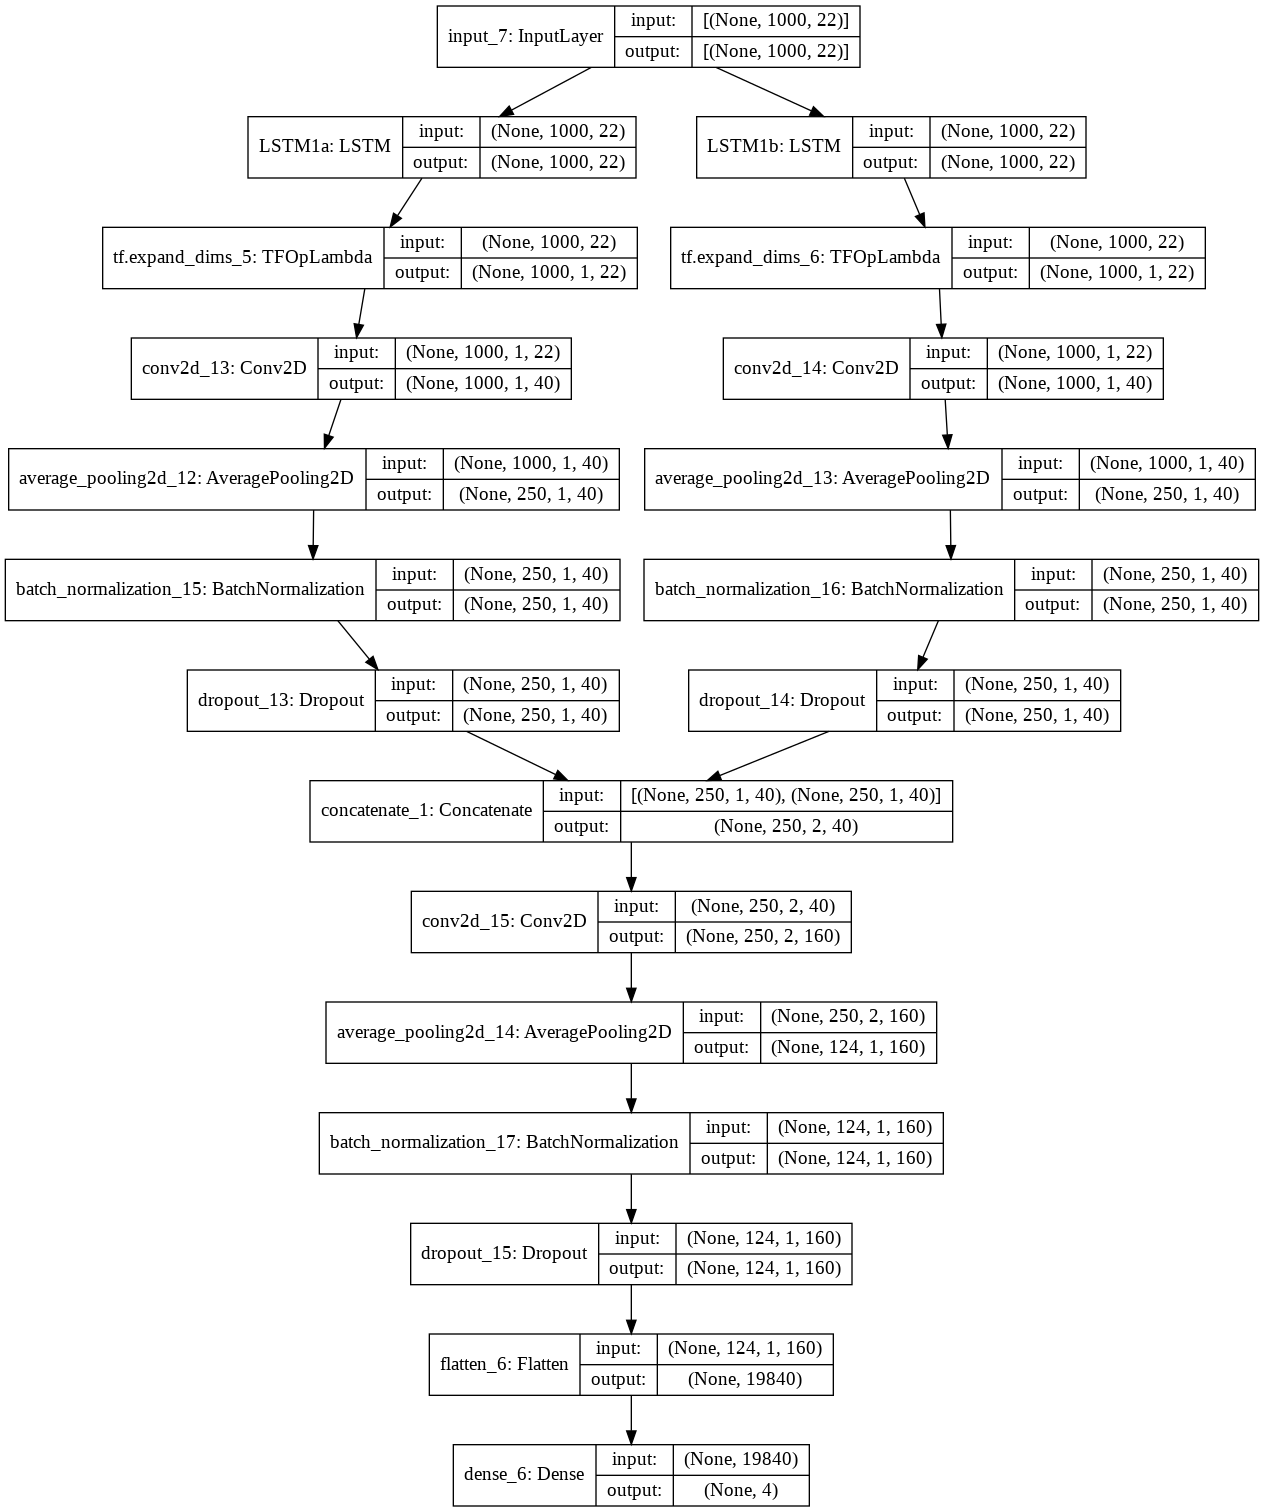

In [ ]:
plot_model(model,"LSTM-CNN-2_constant reg.png",show_shapes=True)

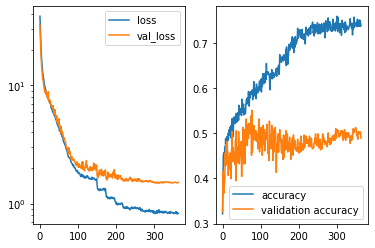

Epoch 00364: early stopping
Val Accuracy 0.4893617033958435
Test Accuracy 0.5327313542366028


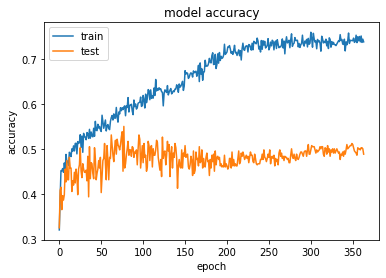

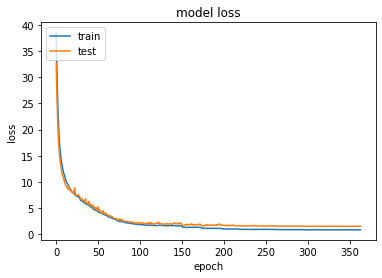

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(Xred_lstm_tv, y_tv_onehot, test_size=0.2)
c_callbacks = get_cb("lstm_new_red_22elu_e600")
history = model.fit(X_train,y_train, batch_size = 64, epochs = 600, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(Xred_lstm_test,y_test_onehot, verbose = 0)
print('Test Accuracy', score[1])

Loss_big_img(history)

changing the loss function and sending raw data

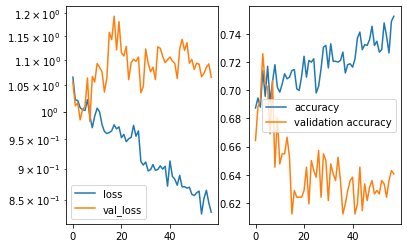

Epoch 00058: early stopping
Val Accuracy 0.6406619548797607
Test Accuracy 0.5485327243804932


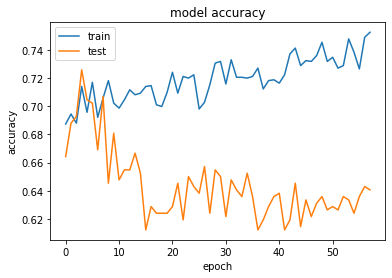

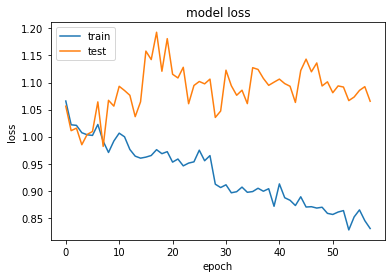

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 1e-4)
model.compile(loss = 'sparse_categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(X_lstm_tv, y_train_valid, test_size=0.2)
c_callbacks = get_cb("lstm_new_loss_22elu_e600")
history = model.fit(X_train,y_train, batch_size = 64, epochs = 600, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score = model.evaluate(X_lstm_test,y_test, verbose = 0)
print('Test Accuracy', score[1])

Loss_big_img(history)

### Scheduled Sampling of inputs

**Attempt** Cropped data (Sampled data) and different numer of LSTM units

In [ ]:
reg1 = regularizers.l1_l2(l1=0.075, l2=0.075)
reg2 = regularizers.l1_l2(l1=0.005, l2=0.005)
reg3 = regularizers.l1_l2(l1=0.001, l2=0.001)
inputs = tf.keras.Input(shape=(800,22))

out1 = layers.LSTM(15, return_sequences=True,kernel_regularizer= reg1,recurrent_regularizer= reg1, name="LSTM1")(inputs)#out1a: None,800,15

out2 = tf.expand_dims(out1, 2)#out3: None, 800,1,15

out3 = layers.Conv2D(40, (8,1), padding = 'same',kernel_regularizer= reg2, activation = 'elu')(out2) #out3: None, 800, 1, 40
out4 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out3) #out4: None, 199+1, 1, 40
out5 = layers.BatchNormalization()(out4) #out5: None, 200,1,40
out6 = layers.Dropout(0.5)(out5) #out6: None, 200, 1, 40

out7 = layers.Conv2D(filters = 160, kernel_size = (8,1),kernel_regularizer= reg2, padding = 'same', activation = 'elu')(out6) #out6: None, 200, 1, 80
out8 = layers.AveragePooling2D(pool_size = (2,1),strides = (2,1))(out7) #out8: None,100, 1, 80
out9 = layers.BatchNormalization()(out8)
out10 = layers.Dropout(0.5)(out9)

out11 = layers.Conv2D(filters = 80, kernel_size = (8,1),kernel_regularizer= reg3, padding = 'same', activation = 'elu')(out10) #out10: None, 100, 1, 80
out12 = layers.AveragePooling2D(pool_size = (2,1),strides = (2,1))(out11) #out11: None,50, 1, 80
out13 = layers.BatchNormalization()(out12)
out14 = layers.Dropout(0.5)(out13)

out15 = layers.Flatten()(out14)
out16 = layers.Dense(4, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)
#model.summary()

optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(Xcrop_lstm_tv, ycrop_tv_onehot, test_size=0.2)
c_callbacks = get_cb("lstm_Der_crop15_changingReg_e800")
history = model.fit(X_train,y_train, batch_size = 256, epochs = 800, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score1 = model.evaluate(Xcrop_lstm_test[0::5],ycrop_test_onehot[0::5], verbose = 0)
print('Test Accuracy', score1[1])
score2 = model.evaluate(Xcrop_lstm_test[1::5],ycrop_test_onehot[1::5], verbose = 0)
print('Test Accuracy', score2[1])
score3 = model.evaluate(Xcrop_lstm_test[2::5],ycrop_test_onehot[2::5], verbose = 0)
print('Test Accuracy', score3[1])
score4 = model.evaluate(Xcrop_lstm_test[3::5],ycrop_test_onehot[3::5], verbose = 0)
print('Test Accuracy', score4[1])
score5 = model.evaluate(Xcrop_lstm_test[4::5],ycrop_test_onehot[4::5], verbose = 0)
print('Test Accuracy', score5[1])

Loss_big_img(history)

15 LSTM units, Inc size of feature maps and same reg

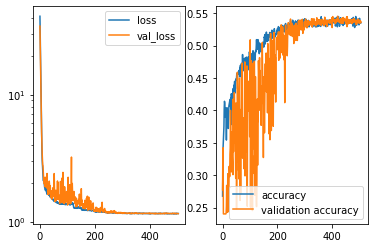

Epoch 00506: early stopping
Val Accuracy 0.5356974005699158
Test Accuracy 0.5146726965904236
Test Accuracy 0.53724604845047
Test Accuracy 0.5259593725204468
Test Accuracy 0.5327313542366028
Test Accuracy 0.44243791699409485


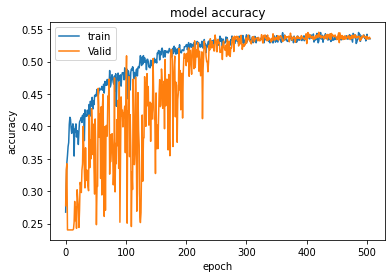

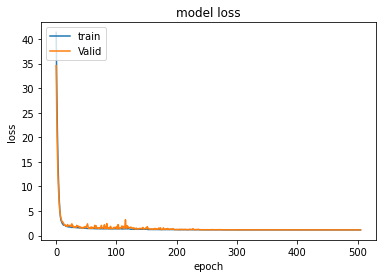

In [ ]:
reg1 = regularizers.l1_l2(l1=0.1, l2=0.1)
reg2 = regularizers.l1_l2(l1=0.005, l2=0.005)
reg3 = regularizers.l1_l2(l1=0.001, l2=0.001)
inputs = tf.keras.Input(shape=(800,22))

out1 = layers.LSTM(15, return_sequences=True,kernel_regularizer= reg1,recurrent_regularizer= reg1, name="LSTM1")(inputs)#out1a: None,800,15

out2 = tf.expand_dims(out1, 2)#out3: None, 800,1,15

out3 = layers.Conv2D(40, (8,1), padding = 'same',kernel_regularizer= reg2, activation = 'elu')(out2) #out3: None, 800, 1, 40
out4 = layers.AveragePooling2D(pool_size = (2,1),strides = (2,1))(out3) #out4: None, 400, 1, 40
out5 = layers.BatchNormalization()(out4) #out5: None, 400,1,40
out6 = layers.Dropout(0.5)(out5) #out6: None, 400, 1, 40

out7 = layers.Conv2D(filters = 160, kernel_size = (8,1),kernel_regularizer= reg2, padding = 'same', activation = 'elu')(out6) #out6: None, 200, 1, 80
out8 = layers.AveragePooling2D(pool_size = (2,1),strides = (2,1))(out7) #out8: None,200, 1, 80
out9 = layers.BatchNormalization()(out8)
out10 = layers.Dropout(0.5)(out9)

out11 = layers.Conv2D(filters = 80, kernel_size = (8,1),kernel_regularizer= reg3, padding = 'same', activation = 'elu')(out10) #out10: None, 100, 1, 80
out12 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out11) #out11: None,50, 1, 80
out13 = layers.BatchNormalization()(out12)
out14 = layers.Dropout(0.5)(out13)

out15 = layers.Flatten()(out14)
out16 = layers.Dense(4, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)
#model.summary()

optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(Xcrop_lstm_tv, ycrop_tv_onehot, test_size=0.2)
c_callbacks = get_cb("lstm_Der_crop15_changingReg_e800")
history = model.fit(X_train,y_train, batch_size = 256, epochs = 800, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score1 = model.evaluate(Xcrop_lstm_test[0::5],ycrop_test_onehot[0::5], verbose = 0)
print('Test Accuracy', score1[1])
score2 = model.evaluate(Xcrop_lstm_test[1::5],ycrop_test_onehot[1::5], verbose = 0)
print('Test Accuracy', score2[1])
score3 = model.evaluate(Xcrop_lstm_test[2::5],ycrop_test_onehot[2::5], verbose = 0)
print('Test Accuracy', score3[1])
score4 = model.evaluate(Xcrop_lstm_test[3::5],ycrop_test_onehot[3::5], verbose = 0)
print('Test Accuracy', score4[1])
score5 = model.evaluate(Xcrop_lstm_test[4::5],ycrop_test_onehot[4::5], verbose = 0)
print('Test Accuracy', score5[1])

Loss_big_img(history)

6 LSTM units and same rest

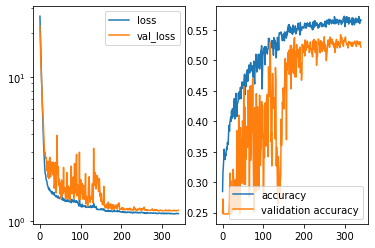

Epoch 00341: early stopping
Val Accuracy 0.5219858288764954
Test Accuracy 0.4898419976234436
Test Accuracy 0.5417607426643372
Test Accuracy 0.5214446783065796
Test Accuracy 0.505643367767334
Test Accuracy 0.45146727561950684


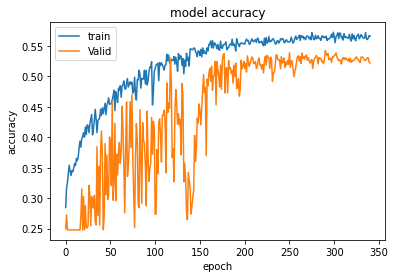

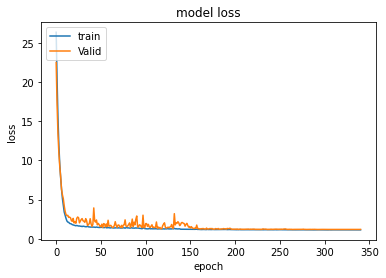

In [ ]:
reg1 = regularizers.l1_l2(l1=0.1, l2=0.1)
reg2 = regularizers.l1_l2(l1=0.005, l2=0.005)
reg3 = regularizers.l1_l2(l1=0.001, l2=0.001)
inputs = tf.keras.Input(shape=(800,22))

out1 = layers.LSTM(6, return_sequences=True,kernel_regularizer= reg1,recurrent_regularizer= reg1, name="LSTM1")(inputs)#out1a: None,800,6

out2 = tf.expand_dims(out1, 2)#out3: None, 800,1,6

out3 = layers.Conv2D(40, (8,1), padding = 'same',kernel_regularizer= reg2, activation = 'elu')(out2) #out3: None, 800, 1, 40
out4 = layers.AveragePooling2D(pool_size = (2,1),strides = (2,1))(out3) #out4: None, 400, 1, 40
out5 = layers.BatchNormalization()(out4) #out5: None, 400,1,40
out6 = layers.Dropout(0.5)(out5) #out6: None, 400, 1, 40

out7 = layers.Conv2D(filters = 160, kernel_size = (8,1),kernel_regularizer= reg2, padding = 'same', activation = 'elu')(out6) #out6: None, 200, 1, 80
out8 = layers.AveragePooling2D(pool_size = (2,1),strides = (2,1))(out7) #out8: None,200, 1, 80
out9 = layers.BatchNormalization()(out8)
out10 = layers.Dropout(0.5)(out9)

out11 = layers.Conv2D(filters = 80, kernel_size = (8,1),kernel_regularizer= reg3, padding = 'same', activation = 'elu')(out10) #out10: None, 100, 1, 80
out12 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out11) #out11: None,50, 1, 80
out13 = layers.BatchNormalization()(out12)
out14 = layers.Dropout(0.5)(out13)

out15 = layers.Flatten()(out14)
out16 = layers.Dense(4, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)
#model.summary()

optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(Xcrop_lstm_tv, ycrop_tv_onehot, test_size=0.2)
c_callbacks = get_cb("lstm_Der_crop6_changingReg_e700")
history = model.fit(X_train,y_train, batch_size = 256, epochs = 700, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score1 = model.evaluate(Xcrop_lstm_test[0::5],ycrop_test_onehot[0::5], verbose = 0)
print('Test Accuracy', score1[1])
score2 = model.evaluate(Xcrop_lstm_test[1::5],ycrop_test_onehot[1::5], verbose = 0)
print('Test Accuracy', score2[1])
score3 = model.evaluate(Xcrop_lstm_test[2::5],ycrop_test_onehot[2::5], verbose = 0)
print('Test Accuracy', score3[1])
score4 = model.evaluate(Xcrop_lstm_test[3::5],ycrop_test_onehot[3::5], verbose = 0)
print('Test Accuracy', score4[1])
score5 = model.evaluate(Xcrop_lstm_test[4::5],ycrop_test_onehot[4::5], verbose = 0)
print('Test Accuracy', score5[1])

Loss_big_img(history)

LSTM 15 lower reg

### LSTM-CNN_adaptive reg-4

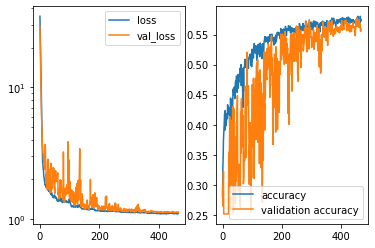

Epoch 00467: early stopping
Val Accuracy 0.5598108768463135
Test Accuracy 0.51241534948349
Test Accuracy 0.5349887013435364
Test Accuracy 0.530474066734314
Test Accuracy 0.5011286735534668
Test Accuracy 0.45372459292411804


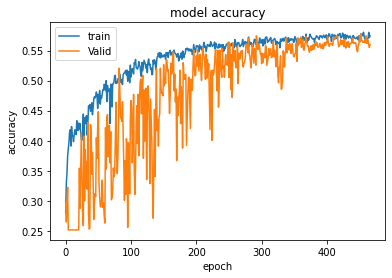

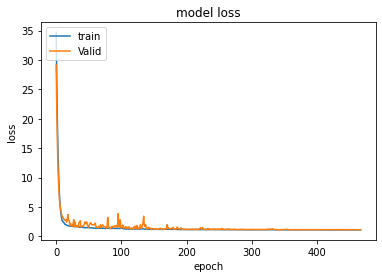

In [ ]:
reg1 = regularizers.l1_l2(l1=0.075, l2=0.075)
reg2 = regularizers.l1_l2(l1=0.005, l2=0.005)
reg3 = regularizers.l1_l2(l1=0.001, l2=0.001)
inputs = tf.keras.Input(shape=(800,22))

out1 = layers.LSTM(15, return_sequences=True,kernel_regularizer= reg1,recurrent_regularizer= reg1, name="LSTM1")(inputs)#out1a: None,800,15

out2 = tf.expand_dims(out1, 2)#out3: None, 800,1,15

out3 = layers.Conv2D(40, (8,1), padding = 'same',kernel_regularizer= reg2, activation = 'elu')(out2) #out3: None, 800, 1, 40
out4 = layers.AveragePooling2D(pool_size = (2,1),strides = (2,1))(out3) #out4: None, 400, 1, 40
out5 = layers.BatchNormalization()(out4) #out5: None, 400,1,40
out6 = layers.Dropout(0.5)(out5) #out6: None, 400, 1, 40

out7 = layers.Conv2D(filters = 160, kernel_size = (8,1),kernel_regularizer= reg2, padding = 'same', activation = 'elu')(out6) #out6: None, 200, 1, 80
out8 = layers.AveragePooling2D(pool_size = (2,1),strides = (2,1))(out7) #out8: None,200, 1, 80
out9 = layers.BatchNormalization()(out8)
out10 = layers.Dropout(0.5)(out9)

out11 = layers.Conv2D(filters = 80, kernel_size = (8,1),kernel_regularizer= reg3, padding = 'same', activation = 'elu')(out10) #out10: None, 100, 1, 80
out12 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out11) #out11: None,50, 1, 80
out13 = layers.BatchNormalization()(out12)
out14 = layers.Dropout(0.5)(out13)

out15 = layers.Flatten()(out14)
out16 = layers.Dense(4, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)
#model.summary()

optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(Xcrop_lstm_tv, ycrop_tv_onehot, test_size=0.2)
c_callbacks = get_cb("lstm_Der_crop15_loweroverallReg_e700")
history = model.fit(X_train,y_train, batch_size = 256, epochs = 700, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score1 = model.evaluate(Xcrop_lstm_test[0::5],ycrop_test_onehot[0::5], verbose = 0)
print('Test Accuracy', score1[1])
score2 = model.evaluate(Xcrop_lstm_test[1::5],ycrop_test_onehot[1::5], verbose = 0)
print('Test Accuracy', score2[1])
score3 = model.evaluate(Xcrop_lstm_test[2::5],ycrop_test_onehot[2::5], verbose = 0)
print('Test Accuracy', score3[1])
score4 = model.evaluate(Xcrop_lstm_test[3::5],ycrop_test_onehot[3::5], verbose = 0)
print('Test Accuracy', score4[1])
score5 = model.evaluate(Xcrop_lstm_test[4::5],ycrop_test_onehot[4::5], verbose = 0)
print('Test Accuracy', score5[1])

Loss_big_img(history)

In [ ]:
#@title
inputs = tf.keras.Input(shape=(800,22))

out1 = layers.LSTM(15, return_sequences=True,kernel_regularizer= reg1,recurrent_regularizer= reg1, name="LSTM1")(inputs)#out1a: None,800,15

out2 = tf.expand_dims(out1, 2)#out3: None, 800,1,15

out3 = layers.Conv2D(40, (8,1), padding = 'same',kernel_regularizer= reg2, activation = 'elu')(out2) #out3: None, 800, 1, 40
out4 = layers.AveragePooling2D(pool_size = (2,1),strides = (2,1))(out3) #out4: None, 400, 1, 40
out5 = layers.BatchNormalization()(out4) #out5: None, 400,1,40
out6 = layers.Dropout(0.5)(out5) #out6: None, 400, 1, 40

out7 = layers.Conv2D(filters = 160, kernel_size = (8,1),kernel_regularizer= reg2, padding = 'same', activation = 'elu')(out6) #out6: None, 200, 1, 80
out8 = layers.AveragePooling2D(pool_size = (2,1),strides = (2,1))(out7) #out8: None,200, 1, 80
out9 = layers.BatchNormalization()(out8)
out10 = layers.Dropout(0.5)(out9)

out11 = layers.Conv2D(filters = 80, kernel_size = (8,1),kernel_regularizer= reg3, padding = 'same', activation = 'elu')(out10) #out10: None, 100, 1, 80
out12 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out11) #out11: None,50, 1, 80
out13 = layers.BatchNormalization()(out12)
out14 = layers.Dropout(0.5)(out13)

out15 = layers.Flatten()(out14)
out16 = layers.Dense(4, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 800, 22)]         0         
_________________________________________________________________
LSTM1 (LSTM)                 (None, 800, 15)           2280      
_________________________________________________________________
tf.expand_dims_7 (TFOpLambda (None, 800, 1, 15)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 800, 1, 40)        4840      
_________________________________________________________________
average_pooling2d_15 (Averag (None, 400, 1, 40)        0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 400, 1, 40)        160       
_________________________________________________________________
dropout_16 (Dropout)         (None, 400, 1, 40)        0   

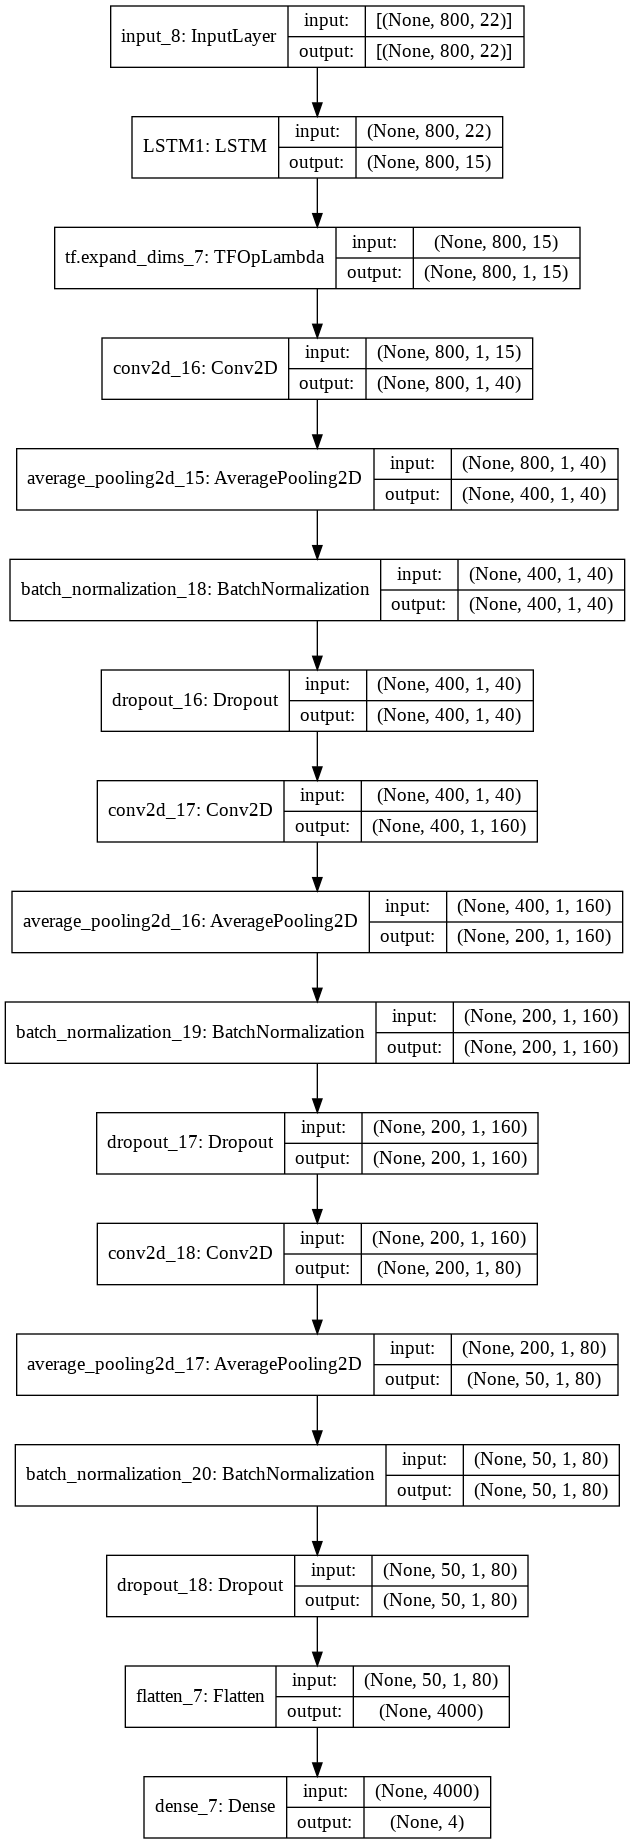

In [ ]:
plot_model(model,"LSTM-CNN_adaptive reg-4.png",show_shapes=True)

**Attempt** ConvLSTM with cropped (scheduled sampling) data

In [ ]:
reg1 = regularizers.l1_l2(l1=0.1, l2=0.1)
reg2 = regularizers.l1_l2(l1=0.005, l2=0.005)
reg3 = regularizers.l1_l2(l1=0.001, l2=0.001)
seq = tf.keras.Sequential(
    [
        tf.keras.Input(
            shape=(800, 6, 7, 1)
        ),  
        layers.ConvLSTM2D(
            filters=30, kernel_size=(3, 3), kernel_regularizer= reg1,recurrent_regularizer= reg1, padding="same", return_sequences=True
        ),#out: (None, 800, 6, 7 , 30)
        layers.BatchNormalization(),
        layers.Dropout(0.5),
     
        layers.ConvLSTM2D(
            filters=30, kernel_size=(3, 3), kernel_regularizer= reg1,recurrent_regularizer= reg1, padding="same"
        ),#out:(None, 1,6,7,30)
        #layers.Lambda(lambda x: x[0, :, :, :])#out:(None,6,7,30)
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Conv2D(
            filters=30, kernel_size=(3, 3), kernel_regularizer= reg2, activation="relu", padding="same"
        ),

        layers.Flatten(),
     
        layers.Dense(4, activation="softmax"),
    ]
)
seq.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 800, 6, 7, 30)     33600     
_________________________________________________________________
batch_normalization (BatchNo (None, 800, 6, 7, 30)     120       
_________________________________________________________________
dropout (Dropout)            (None, 800, 6, 7, 30)     0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 6, 7, 30)          64920     
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 7, 30)          120       
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 7, 30)          0         
_________________________________________________________________
conv2d (Conv2D)              (None, 6, 7, 30)          8

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
seq.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(Xcrop_clstm_tv, ycropnew_tv_onehot, test_size=0.2)
c_callbacks = get_cb("Clstm_crop_350")
history = seq.fit(X_train,y_train, batch_size = 128, epochs = 50, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = seq.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score1 = model.evaluate(Xcrop_clstm_test[0::5],ycropnew_test_onehot[0::5], verbose = 0)
print('Test Accuracy', score1[1])
score2 = model.evaluate(Xcrop_clstm_test[1::5],ycropnew_test_onehot[1::5], verbose = 0)
print('Test Accuracy', score2[1])
score3 = model.evaluate(Xcrop_clstm_test[2::5],ycropnew_test_onehot[2::5], verbose = 0)
print('Test Accuracy', score3[1])
score4 = model.evaluate(Xcrop_clstm_test[3::5],ycropnew_test_onehot[3::5], verbose = 0)
print('Test Accuracy', score4[1])
score5 = model.evaluate(Xcrop_clstm_test[4::5],ycropnew_test_onehot[4::5], verbose = 0)
print('Test Accuracy', score5[1])

Loss_big_img(history)

Epoch 1/50


ResourceExhaustedError: ignored

<Figure size 720x720 with 0 Axes>

### Inputs in the form a spatial map of electrodes
**Attempt** Brian image as input and LSTM at the end

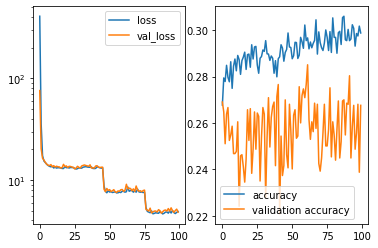

Val Accuracy 0.2676122784614563
Test Accuracy 0.248307004570961
Test Accuracy 0.2799097001552582
Test Accuracy 0.2573363482952118
Test Accuracy 0.248307004570961
Test Accuracy 0.2550790011882782


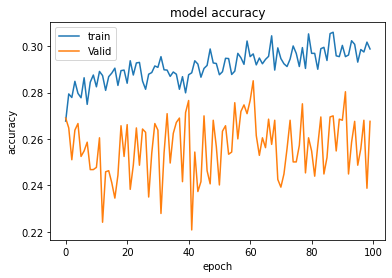

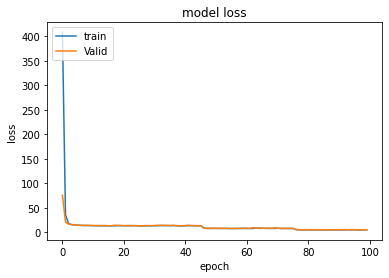

In [ ]:
reg1 = regularizers.l1_l2(l1=0.1, l2=0.1)
reg2 = regularizers.l1_l2(l1=0.005, l2=0.005)
reg3 = regularizers.l1_l2(l1=0.001, l2=0.001)

inputs = tf.keras.Input(shape=(6,7,800))

out1 = layers.Conv2D(120, (3,3), padding = 'same',kernel_regularizer= reg1, activation = 'elu')(inputs) #out3: None, 6,7,120
out2 = layers.BatchNormalization()(out1) #out5: None, 400,1,40
out3 = layers.Dropout(0.5)(out2) #out6: None, 400, 1, 40

out4 = layers.Conv2D(filters = 160, kernel_size = (5,5),kernel_regularizer= reg2, padding = 'same', activation = 'elu')(out3) #out6: None, 6,7,160
out5 = layers.AveragePooling2D(pool_size = (2,2),strides = (1,1))(out4) #out8: None,5,6,160
out6 = layers.BatchNormalization()(out5)
out7 = layers.Dropout(0.5)(out6)

out8 = layers.Conv2D(filters = 80, kernel_size = (3,3),kernel_regularizer= reg3, padding = 'same', activation = 'elu')(out7) #out10: None, 5,6,80
out9 = layers.AveragePooling2D(pool_size = (2,2),strides = (1,1))(out8) #out11: None,4,5,80
out10 = layers.BatchNormalization()(out9)
out11 = layers.Dropout(0.5)(out10)

out12 = layers.Permute((3,1,2))(out11)
out13 = layers.Reshape((80,20))(out12)
out14 = layers.LSTM(12, return_sequences=True,kernel_regularizer= reg2 ,recurrent_regularizer= reg2, name="LSTM1")(out13)

out15 = layers.Flatten()(out14)
out16 = layers.Dense(4, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)
#model.summary()

optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(Xcropnew_tv, ycropnew_tv_onehot, test_size=0.2)
c_callbacks = get_cb("CropImg_e300")
history = model.fit(X_train,y_train, batch_size = 256, epochs = 100, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score1 = model.evaluate(Xcropnew_test[0::5],ycropnew_test_onehot[0::5], verbose = 0)
print('Test Accuracy', score1[1])
score2 = model.evaluate(Xcropnew_test[1::5],ycropnew_test_onehot[1::5], verbose = 0)
print('Test Accuracy', score2[1])
score3 = model.evaluate(Xcropnew_test[2::5],ycropnew_test_onehot[2::5], verbose = 0)
print('Test Accuracy', score3[1])
score4 = model.evaluate(Xcropnew_test[3::5],ycropnew_test_onehot[3::5], verbose = 0)
print('Test Accuracy', score4[1])
score5 = model.evaluate(Xcropnew_test[4::5],ycropnew_test_onehot[4::5], verbose = 0)
print('Test Accuracy', score5[1])

Loss_big_img(history)

**Attempt** Brian image Without LSTM at the end

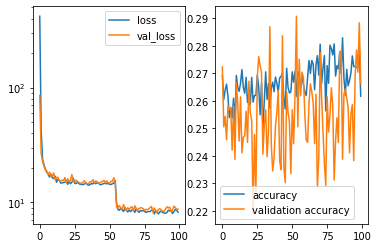

Val Accuracy 0.26619386672973633
Test Accuracy 0.277652382850647
Test Accuracy 0.252821683883667
Test Accuracy 0.284424364566803
Test Accuracy 0.2505643367767334
Test Accuracy 0.2370203137397766


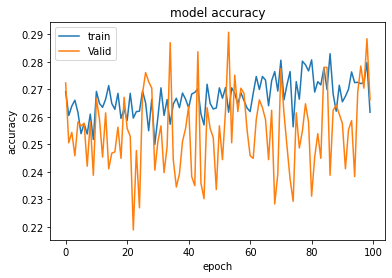

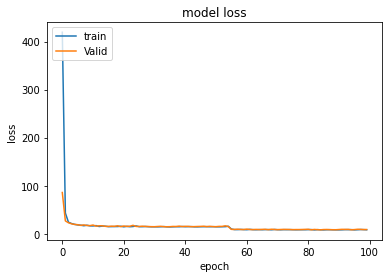

In [ ]:
reg1 = regularizers.l1_l2(l1=0.1, l2=0.1)
reg2 = regularizers.l1_l2(l1=0.005, l2=0.005)
reg3 = regularizers.l1_l2(l1=0.001, l2=0.001)

inputs = tf.keras.Input(shape=(6,7,800))

out1 = layers.Conv2D(120, (3,3), padding = 'same',kernel_regularizer= reg1, activation = 'elu')(inputs) #out3: None, 6,7,120
out2 = layers.BatchNormalization()(out1) #out5: None, 400,1,40
out3 = layers.Dropout(0.5)(out2) #out6: None, 400, 1, 40

out4 = layers.Conv2D(filters = 160, kernel_size = (5,5),kernel_regularizer= reg2, padding = 'same', activation = 'elu')(out3) #out6: None, 6,7,160
out5 = layers.AveragePooling2D(pool_size = (2,2),strides = (1,1))(out4) #out8: None,5,6,160
out6 = layers.BatchNormalization()(out5)
out7 = layers.Dropout(0.5)(out6)

out8 = layers.Conv2D(filters = 80, kernel_size = (3,3),kernel_regularizer= reg3, padding = 'same', activation = 'elu')(out7) #out10: None, 5,6,80
out9 = layers.AveragePooling2D(pool_size = (2,2),strides = (1,1))(out8) #out11: None,4,5,80
out10 = layers.BatchNormalization()(out9)
out11 = layers.Dropout(0.5)(out10)

#out12 = layers.Permute((3,1,2))(out11)
#out13 = layers.Reshape((80,20))(out12)
#out14 = layers.LSTM(12, return_sequences=True,kernel_regularizer= reg2 ,recurrent_regularizer= reg2, name="LSTM1")(out13)

out15 = layers.Flatten()(out11)
out16 = layers.Dense(4, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)
#model.summary()

optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(Xcropnew_tv, ycropnew_tv_onehot, test_size=0.2)
c_callbacks = get_cb("CropImg_noLSTM_e300")
history = model.fit(X_train,y_train, batch_size = 256, epochs = 100, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

score = model.evaluate(X_val ,y_val, verbose = 0)
print('Val Accuracy', score[1])

score1 = model.evaluate(Xcropnew_test[0::5],ycropnew_test_onehot[0::5], verbose = 0)
print('Test Accuracy', score1[1])
score2 = model.evaluate(Xcropnew_test[1::5],ycropnew_test_onehot[1::5], verbose = 0)
print('Test Accuracy', score2[1])
score3 = model.evaluate(Xcropnew_test[2::5],ycropnew_test_onehot[2::5], verbose = 0)
print('Test Accuracy', score3[1])
score4 = model.evaluate(Xcropnew_test[3::5],ycropnew_test_onehot[3::5], verbose = 0)
print('Test Accuracy', score4[1])
score5 = model.evaluate(Xcropnew_test[4::5],ycropnew_test_onehot[4::5], verbose = 0)
print('Test Accuracy', score5[1])

Loss_big_img(history)

### Training on individual persons

One-vs-One and One-vs-All

Using only one person for training
- using only raw data on the best model

In [ ]:
reg1 = regularizers.l1_l2(l1=0.1, l2=0.1)
reg2 = regularizers.l1_l2(l1=0.005, l2=0.005)
reg3 = regularizers.l1_l2(l1=0.001, l2=0.001)

inputs = tf.keras.Input(shape=(1000,22))

out1 = layers.LSTM(15, return_sequences=True,kernel_regularizer= reg1,recurrent_regularizer= reg1, name="LSTM1")(inputs)#out1a: None,1000,15

out2 = tf.expand_dims(out1, 2)#out3: None, 1000,1,15

out3 = layers.Conv2D(40, (8,1), padding = 'same',kernel_regularizer= reg2, activation = 'elu')(out2) #out3: None, 1000, 1, 40
out4 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out3) #out4: None, 249+1, 1, 40
out5 = layers.BatchNormalization()(out4) #out5: None, 250,1,40
out6 = layers.Dropout(0.5)(out5) #out6: None, 250, 1, 40

out7 = layers.Conv2D(filters = 160, kernel_size = (8,1),kernel_regularizer= reg2, padding = 'same', activation = 'elu')(out6) #out6: None, 250, 1, 80
out8 = layers.AveragePooling2D(pool_size = (4,1),strides = (2,1))(out7) #out8: None,124, 1, 80
out9 = layers.BatchNormalization()(out8)
out10 = layers.Dropout(0.5)(out9)

out11 = layers.Conv2D(filters = 80, kernel_size = (8,1),kernel_regularizer= reg3, padding = 'same', activation = 'elu')(out10) #out10: None, 124, 1, 80
out12 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out11) #out11: None,31, 1, 80
out13 = layers.BatchNormalization()(out12)
out14 = layers.Dropout(0.5)(out13)

out15 = layers.Flatten()(out14)
out16 = layers.Dense(4, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)
#model.summary()

optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

In [ ]:
print(np.unique(person_train_valid))
print(np.unique(person_test))
peeps = np.unique(person_train_valid)

[0. 1. 2. 3. 4. 5. 6. 7. 8.]
[0. 1. 2. 3. 4. 5. 6. 7. 8.]


In [ ]:
for p in peeps[0:2]:
  pind = np.squeeze(person_train_valid==p)
 # print(np.squeeze(pind).shape)
  xx = X_lstm_tv[pind]
  print(xx.shape)
  

(237, 1000, 22)
(236, 1000, 22)


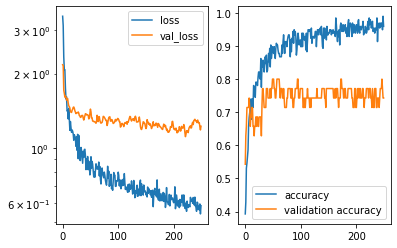

*****************
Training on person 0:
Val acc is 0.8333333134651184
Test acc on person 0 is 0.6000000238418579
Test acc on all subjects is 0.3702031672000885
*****************
Training on person 1:
Val acc is 0.6666666865348816
Test acc on person 1 is 0.6000000238418579
Test acc on all subjects is 0.3882618546485901
*****************
Training on person 2:
Val acc is 0.8333333134651184
Test acc on person 2 is 0.5799999833106995
Test acc on all subjects is 0.41986456513404846
*****************
Training on person 3:
Val acc is 0.5277777910232544
Test acc on person 3 is 0.5
Test acc on all subjects is 0.3769751787185669
*****************
Training on person 4:
Val acc is 0.6388888955116272
Test acc on person 4 is 0.6382978558540344
Test acc on all subjects is 0.3905192017555237
*****************
Training on person 5:
Val acc is 0.6388888955116272
Test acc on person 5 is 0.5102040767669678
Test acc on all subjects is 0.3679458200931549
*****************
Training on person 6:
Val acc is 0.7

In [ ]:
Valacc = []
Testacc_person = []
Testacc_all = []
for p in peeps:
    pind = np.squeeze(person_train_valid==p)
    X_train, X_val, y_train, y_val = train_test_split(X_lstm_tv[pind], y_tv_onehot[pind], test_size=0.15)
    c_callbacks = get_cb("Person_{} training e250".format(p))
    history = model.fit(X_train,y_train, batch_size = 16, epochs = 250, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

    score = model.evaluate(X_val ,y_val, verbose = 0)
    Valacc.append(score[1])
    #print('Val Accuracy', score[1])

    pind = np.squeeze(person_test==p)
    score = model.evaluate(X_lstm_test[pind],y_test_onehot[pind], verbose = 0)
    Testacc_person.append(score[1])
    #print('Test Accuracy on person {} is'.format(p), score[1])
    score = model.evaluate(X_lstm_test,y_test_onehot, verbose = 0)
    Testacc_all.append(score[1])
    #print('Test Accuracy on entire testset', score[1])

    #Loss_big_img(history)
for p in range(9):
  print("*****************")
  print("Training on person {}:".format(p))
  print("Val acc is".format(p), Valacc[p])
  print("Test acc on person {} is".format(p), Testacc_person[p])
  print("Test acc on all subjects is", Testacc_all[p])

In [ ]:
reg1 = regularizers.l1_l2(l1=0.1, l2=0.1)
reg2 = regularizers.l1_l2(l1=0.005, l2=0.005)
reg3 = regularizers.l1_l2(l1=0.001, l2=0.001)

inputs = tf.keras.Input(shape=(1000,22))

out1 = layers.LSTM(22, return_sequences=True,kernel_regularizer= reg1,recurrent_regularizer= reg1, name="LSTM1")(inputs)#out1a: None,1000,22

out2 = tf.expand_dims(out1, 2)#out3: None, 1000,1,22

out3 = layers.Conv2D(40, (8,1), padding = 'same',kernel_regularizer= reg2, activation = 'elu')(out2) #out3: None, 1000, 1, 40
out4 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out3) #out4: None, 249+1, 1, 40
out5 = layers.BatchNormalization()(out4) #out5: None, 250,1,40
out6 = layers.Dropout(0.5)(out5) #out6: None, 250, 1, 40

out7 = layers.Conv2D(filters = 160, kernel_size = (8,1),kernel_regularizer= reg2, padding = 'same', activation = 'elu')(out6) #out6: None, 250, 1, 80
out8 = layers.AveragePooling2D(pool_size = (4,1),strides = (2,1))(out7) #out8: None,124, 1, 80
out9 = layers.BatchNormalization()(out8)
out10 = layers.Dropout(0.5)(out9)

out11 = layers.Conv2D(filters = 80, kernel_size = (8,1),kernel_regularizer= reg3, padding = 'same', activation = 'elu')(out10) #out10: None, 124, 1, 80
out12 = layers.AveragePooling2D(pool_size = (4,1),strides = (4,1))(out11) #out11: None,31, 1, 80
out13 = layers.BatchNormalization()(out12)
out14 = layers.Dropout(0.5)(out13)

out15 = layers.Flatten()(out14)
out16 = layers.Dense(4, activation="softmax")(out15)

model = tf.keras.Model(inputs, out16)
#model.summary()

optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

In [ ]:
print(np.unique(person_train_valid))
print(np.unique(person_test))
peeps = np.unique(person_train_valid)

[0. 1. 2. 3. 4. 5. 6. 7. 8.]
[0. 1. 2. 3. 4. 5. 6. 7. 8.]


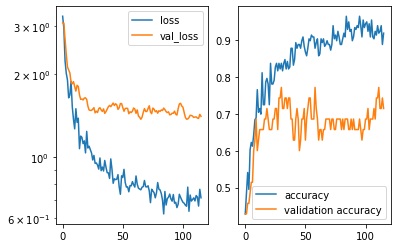

Epoch 00116: early stopping
*****************
Training on person 0:
Val acc is 0.4722222089767456
Test acc on person 0 is 0.6200000047683716
Test acc on all subjects is 0.3860045075416565
*****************
Training on person 1:
Val acc is 0.5
Test acc on person 1 is 0.5799999833106995
Test acc on all subjects is 0.43340858817100525
*****************
Training on person 2:
Val acc is 0.8333333134651184
Test acc on person 2 is 0.699999988079071
Test acc on all subjects is 0.41986456513404846
*****************
Training on person 3:
Val acc is 0.4444444477558136
Test acc on person 3 is 0.47999998927116394
Test acc on all subjects is 0.43792325258255005
*****************
Training on person 4:
Val acc is 0.75
Test acc on person 4 is 0.7234042286872864
Test acc on all subjects is 0.4650112986564636
*****************
Training on person 5:
Val acc is 0.5555555820465088
Test acc on person 5 is 0.5714285969734192
Test acc on all subjects is 0.41309255361557007
*****************
Training on person 

In [ ]:
Valacc = []
Testacc_person = []
Testacc_all = []
for p in peeps:
    pind = np.squeeze(person_train_valid==p)
    X_train, X_val, y_train, y_val = train_test_split(X_lstm_tv[pind], y_tv_onehot[pind], test_size=0.15)
    c_callbacks = get_cb("Person_{}_22_training e250".format(p))
    history = model.fit(X_train,y_train, batch_size = 16, epochs = 250, validation_data = (X_val,y_val), callbacks=c_callbacks, verbose =  True)

    score = model.evaluate(X_val ,y_val, verbose = 0)
    Valacc.append(score[1])
    #print('Val Accuracy', score[1])

    pind = np.squeeze(person_test==p)
    score = model.evaluate(X_lstm_test[pind],y_test_onehot[pind], verbose = 0)
    Testacc_person.append(score[1])
    #print('Test Accuracy on person {} is'.format(p), score[1])
    score = model.evaluate(X_lstm_test,y_test_onehot, verbose = 0)
    Testacc_all.append(score[1])
    #print('Test Accuracy on entire testset', score[1])

    #Loss_big_img(history)
for p in range(9):
  print("*****************")
  print("Training on person {}:".format(p))
  print("Val acc is".format(p), Valacc[p])
  print("Test acc on person {} is".format(p), Testacc_person[p])
  print("Test acc on all subjects is", Testacc_all[p])